In [1]:
# General Instructions:

# Data file (2D array, shape = time x channels, 200 Hz) contains brain responses to different stimulus 
# (visual and auditory). A seperate CSV file with the timestamps and stimulus types was provided.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
DATA_PATH = '/Users/happyt3/Python/BMI/data/'

# signal processing
from scipy import signal 

# read data
data = np.load(os.path.join(DATA_PATH, 'data.npy'))
timestamps = pd.read_csv(os.path.join(DATA_PATH, 'timestamps.csv'))
timestamps = timestamps.sort_values(by=['timestamp']) # sort data

# sampling frequency
sf = 200
time = np.arange(len(data)) / sf
win = 4 * sf # window length (4 seconds)

# print shape
print('The duration of the dataset is: {} seconds.'.format(data.shape[0]/200))
print('The dataset has: {} channels.'.format(data.shape[1]))

The duration of the dataset is: 250.4 seconds.
The dataset has: 36 channels.


In [2]:
####################
# data preprocessing
####################

# brain signal plot function
def plot_channels(data = data, 
                  x = 'time', 
                  channel_start = 0, channel_end = 36, 
                  time_start = None, time_end = None, 
                  vline = False, 
                  ylimit = None):
    """
    Plot multi(single)-channel brain signal

    Parameters
    ----------
    data : data, data_af, or data_final (default = data)
    x : 'time' or 'freq' (default = time)
    channel_start: 0 ~ 35 (default = 0)
    channel_end: 1 ~ 36 (default = 36)
    time_start: for time plot ONLY, 0 ~ 250.4 (default = None)
    time_end: for time plot ONLY, 0 ~ 250.4 (default = None)
    vline: for time plot ONLY, add vertical lines that show stimulus timing, Ture or False (default = False)
    ylimit: for time plot ONLY, y axis limit (default = None)
    """
    plt.clf()
    n_channels = channel_end - channel_start   
    freqs_max = 0
    psd_max = 0
    fig, axs = plt.subplots(
        nrows = n_channels, 
        sharex = True, sharey = True, 
        figsize = (16, 2 * n_channels), 
        subplot_kw = dict(frameon = False) # removes frames
    )
    # single channel
    if n_channels == 1:
        # time
        if x == 'time':
            # add vertical line
            if vline == True:
                for p in list(timestamps[(timestamps['timestamp'] >= time_start) 
                                         & (timestamps['timestamp'] <= time_end)
                                         & (timestamps['stimulus_type'] == 'visual')] # 003f5c for visual stimulus
                              ['timestamp']):
                    axs.axvline(p, linewidth = 1.5, c = '#003f5c', ls = '--')
                    axs.axvline(p + 0.5, linewidth = 1, c = '#003f5c', ls = '--', alpha = 0.2)
                for p in list(timestamps[(timestamps['timestamp'] >= time_start) 
                                         & (timestamps['timestamp'] <= time_end)
                                         & (timestamps['stimulus_type'] == 'auditory')] # bc5090 for auditory stimulus
                              ['timestamp']):
                    axs.axvline(p, linewidth = 1.5, c = '#bc5090', ls = '--')
                    axs.axvline(p + 0.5, linewidth = 1, c = '#bc5090', ls = '--', alpha = 0.2)
            axs.plot(time, data[:, channel_start])
        # freq
        elif x == 'freq':
            freqs, psd = signal.welch(data[:, channel_start], sf, nperseg = win) # Welch's periodogram
            freqs_max = freqs.max()
            psd_max = psd.max()
            axs.plot(freqs, psd)
        axs.set(ylabel = 'Channel {}'.format(channel_start))
    # multiple channels
    else:
        for i in range(n_channels):
            # time
            if x == 'time':
                # add vertical line
                if vline == True:
                    for p in list(timestamps[(timestamps['timestamp'] >= time_start) 
                                             & (timestamps['timestamp'] <= time_end)
                                             & (timestamps['stimulus_type'] == 'visual')] # 003f5c for visual stimulus
                                  ['timestamp']):
                        axs[i].axvline(p, linewidth = 1.5, c = '#003f5c', ls = '--')
                        axs[i].axvline(p + 0.5, linewidth = 1, c = '#003f5c', ls = '--', alpha = 0.2)
                    for p in list(timestamps[(timestamps['timestamp'] >= time_start) 
                                             & (timestamps['timestamp'] <= time_end)
                                             & (timestamps['stimulus_type'] == 'auditory')] # bc5090 for auditory stimulus
                                  ['timestamp']):
                        axs[i].axvline(p, linewidth = 1.5, c = '#bc5090', ls = '--')
                        axs[i].axvline(p + 0.5, linewidth = 1, c = '#bc5090', ls = '--', alpha = 0.2)
                axs[i].plot(time, data[:, i])
            # freq
            elif x == 'freq':
                freqs, psd = signal.welch(data[:,i], sf, nperseg = win)
                axs[i-channel_start].plot(freqs, psd)
                axs[i-channel_start].set(ylabel = 'Channel {}'.format(i))
                freqs_max = max(freqs_max, freqs.max())
                psd_max = max(psd_max, psd.max())               
            axs[i].set(ylabel = 'Channel {}'.format(i))
        for ax in axs: ax.label_outer() # Hide x labels and tick labels for all but bottom plot.
    # add x label, x limit, and channel number
    if x == 'time':
        plt.xlabel('Time (seconds)')    
        plt.xlim([time_start, time_end])
        if not ylimit:
            pass
        else:
            plt.ylim([-1 * ylimit, ylimit])
    elif x == 'freq':
        plt.xlabel('Frequency (Hz)')
        plt.xlim([0, freqs_max])
        plt.ylim([0, psd_max])
    plt.show()

<Figure size 432x288 with 0 Axes>

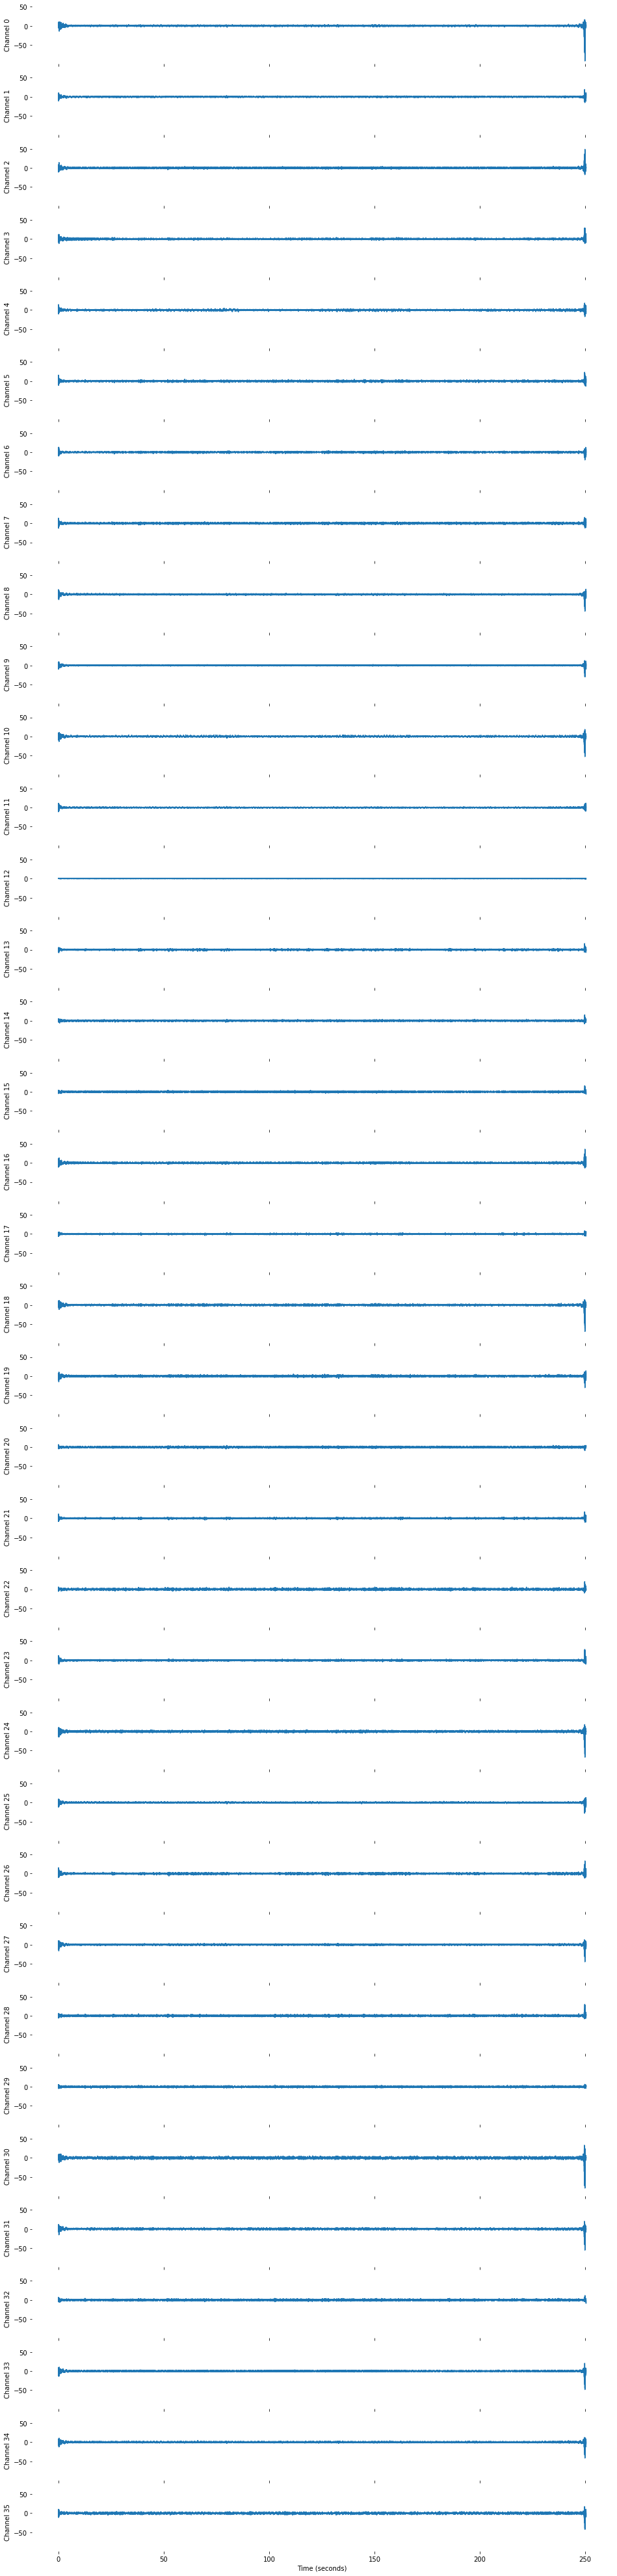

In [3]:
# plot all channels - time
plot_channels(data = data, x = 'time')

In [4]:
# note:
# 1. abnormality at the begining and the end
# 2. channel 12 - no signal

# "Note, we do not expect any relevant neural response more than 0.5 second after a given stimulus."
print('First stimulus (second): {}'.format(timestamps.iloc[0]['timestamp']))
print('Last stimulus (second): {}'.format(timestamps.iloc[-1]['timestamp']))
print('No relevant neural response before: {} seconds'.format(timestamps.iloc[0]['timestamp']))
print('No relevant neural response after: {} seconds'.format(timestamps.iloc[-1]['timestamp'] + 0.5))

import math
start_point = math.floor((timestamps.iloc[0]['timestamp']) * sf) # round down
end_point = math.ceil((timestamps.iloc[-1]['timestamp'] + 0.5) * sf) # round up
# print('Will truncate data before: {}'.format(start_point))
# print('Will truncate data after: {}'.format(end_point))

First stimulus (second): 3.9122254486083983
Last stimulus (second): 244.2466298274994
No relevant neural response before: 3.9122254486083983 seconds
No relevant neural response after: 244.7466298274994 seconds


<Figure size 432x288 with 0 Axes>

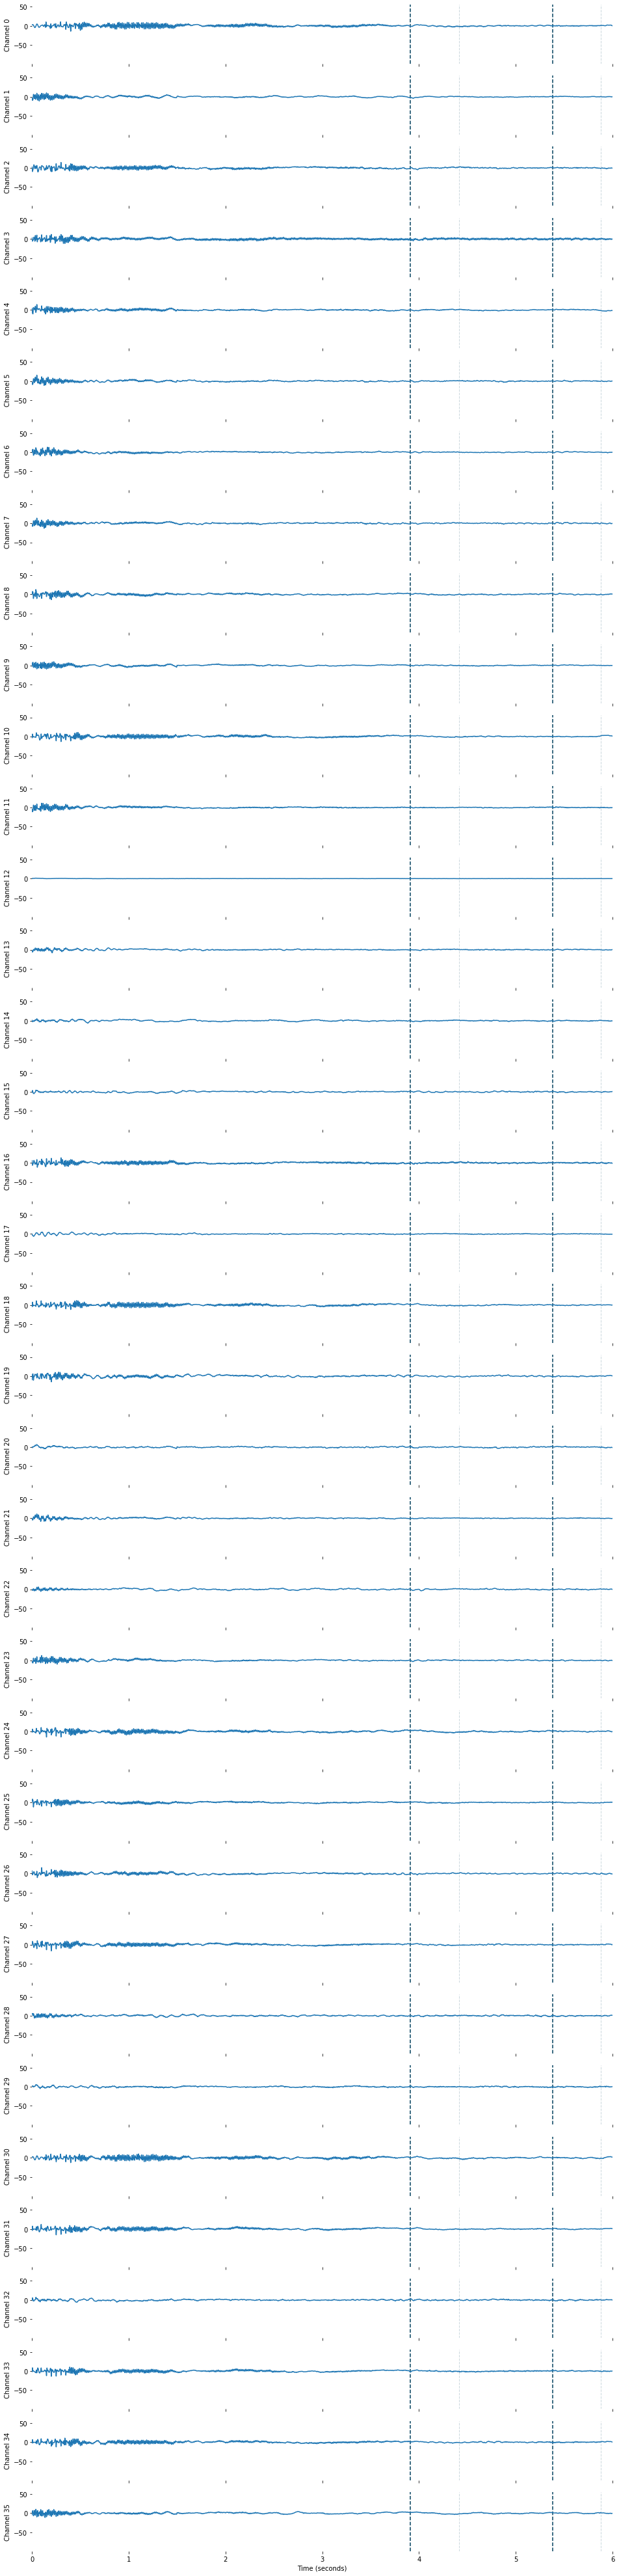

In [5]:
# plot the first 6 seconds
plot_channels(data = data, 
              x = 'time', 
              channel_start = 0, channel_end = 36, 
              time_start = 0, time_end = 6, 
              vline = True)

<Figure size 432x288 with 0 Axes>

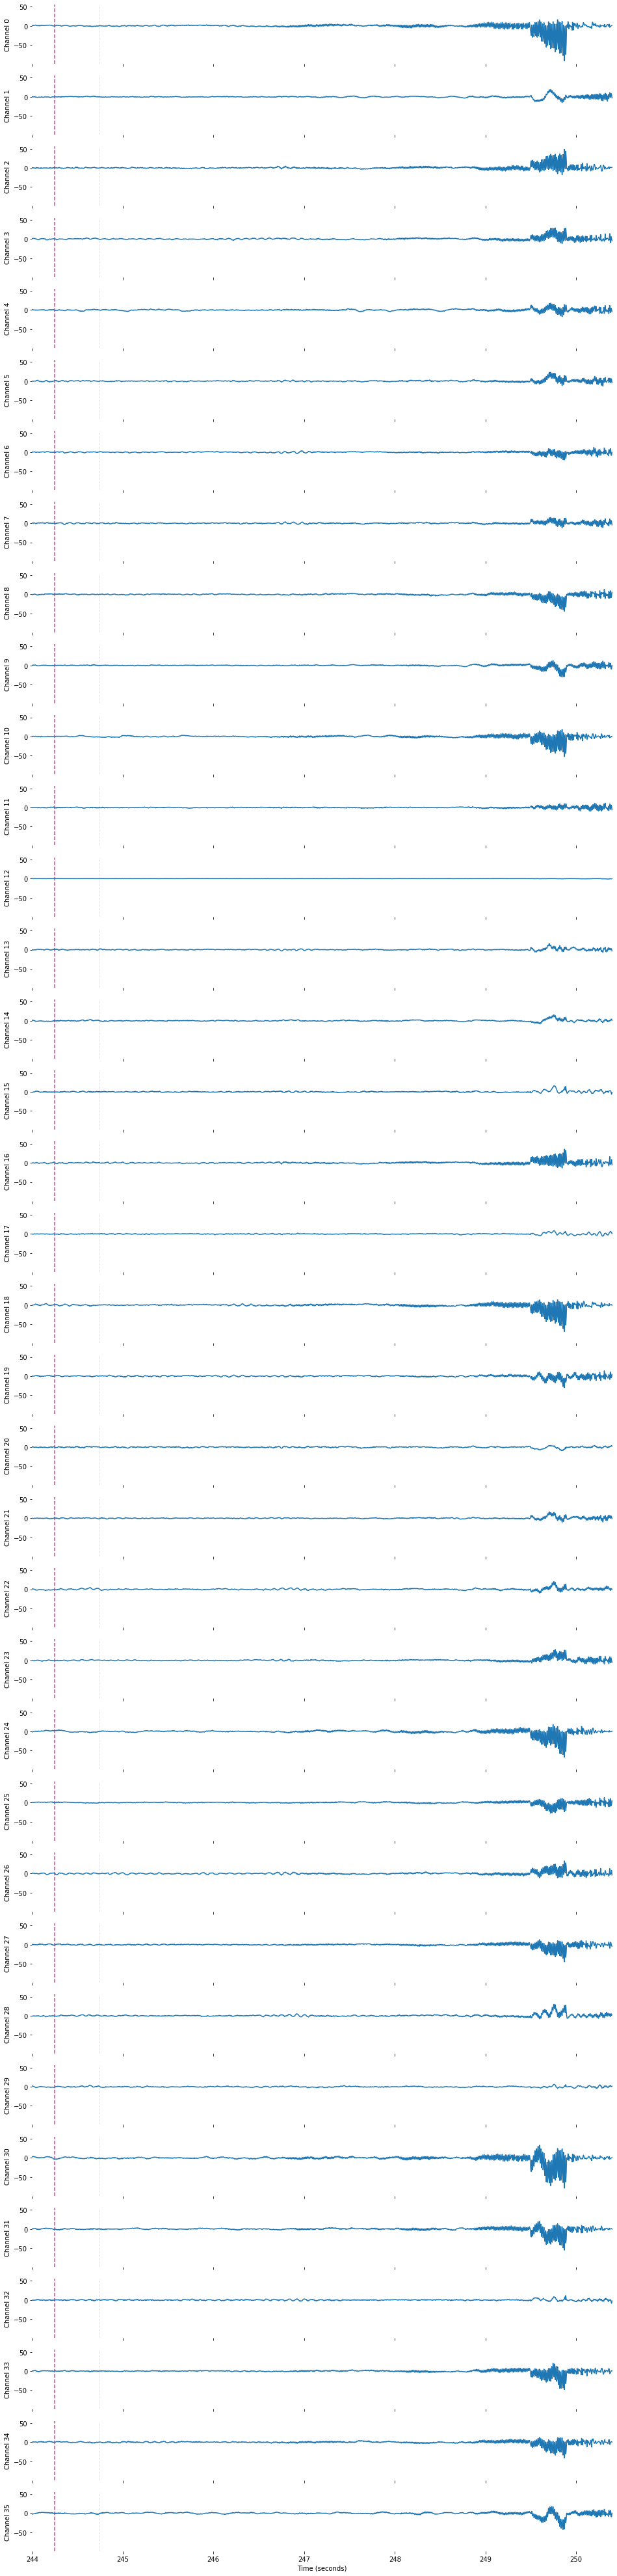

In [6]:
# plot the last 6.4 seconds
plot_channels(data = data, 
              x = 'time', 
              channel_start = 0, channel_end = 36, 
              time_start = 244, time_end = 250.4, 
              vline = True)

<Figure size 432x288 with 0 Axes>

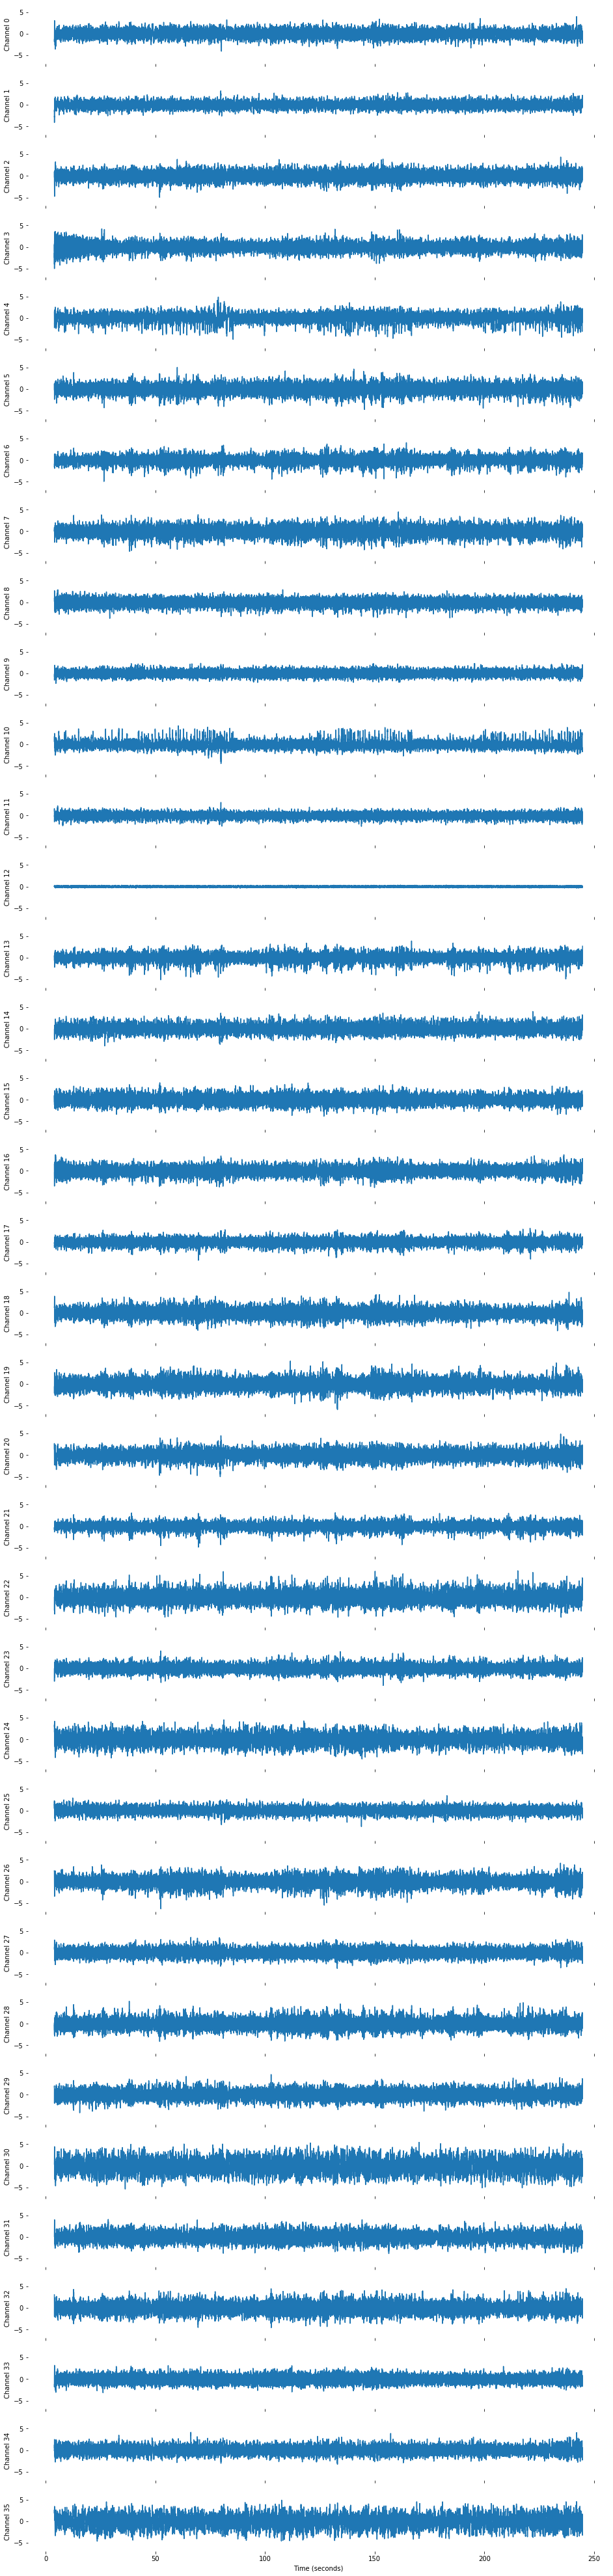

In [7]:
# truncate data
data = data[start_point : end_point+1]
time = np.arange(start_point, end_point+1) / sf

# plot truncated data
plot_channels(data = data, x = 'time')

<Figure size 432x288 with 0 Axes>

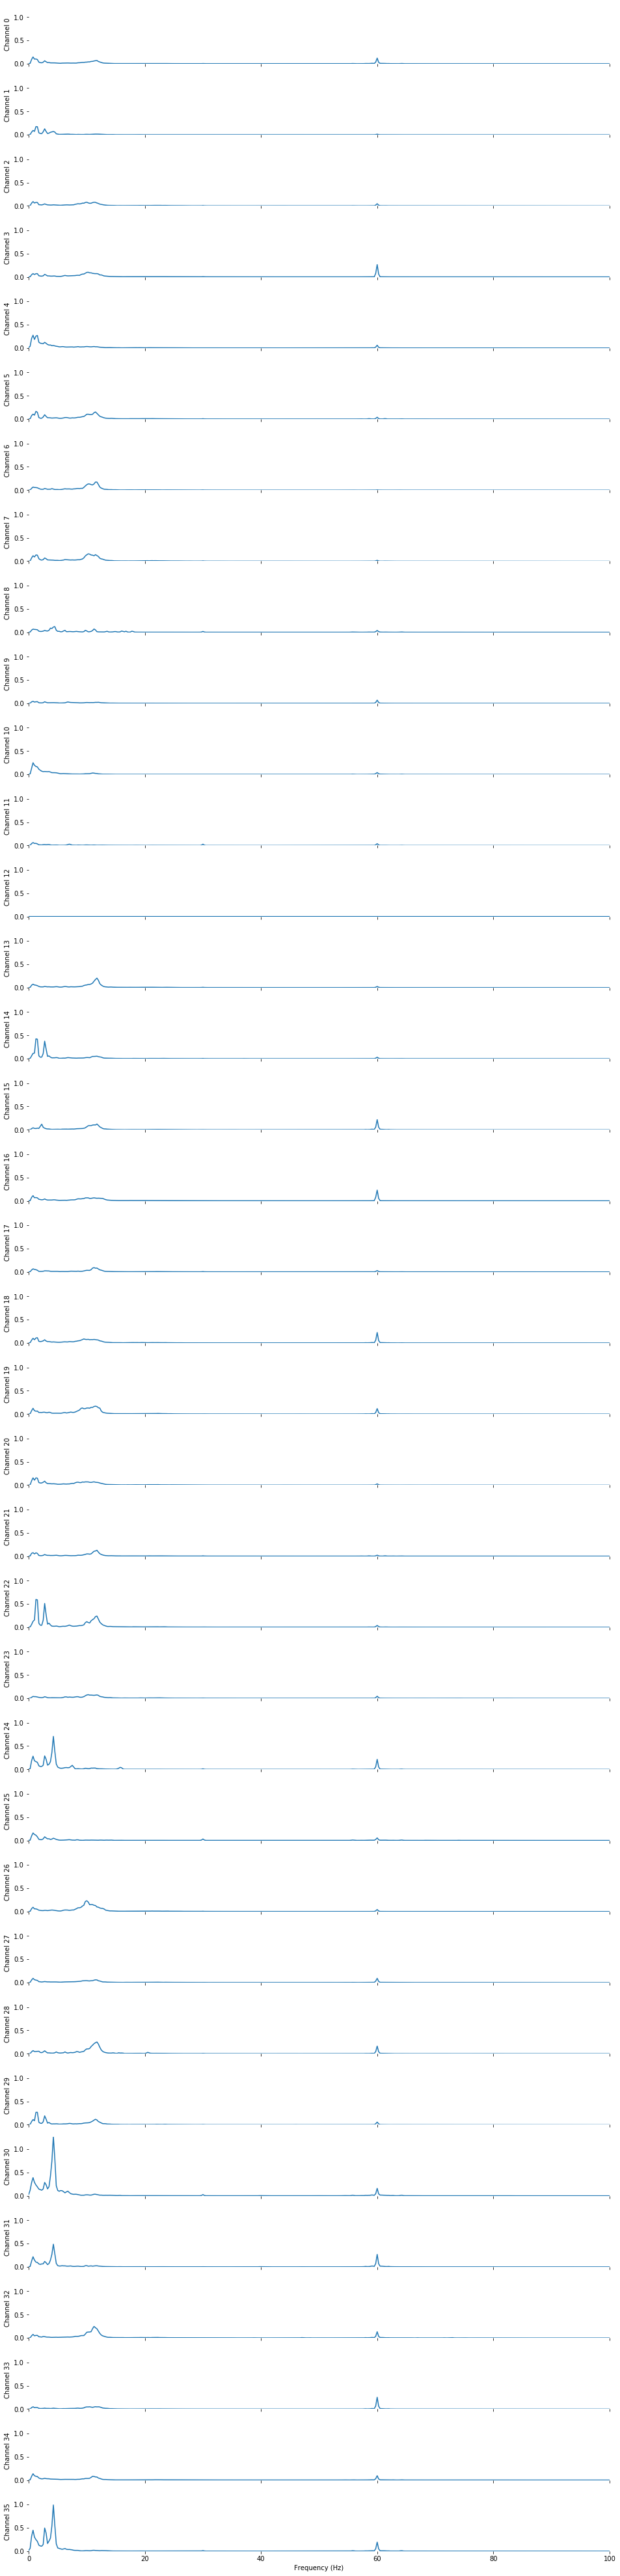

In [8]:
# plot - freq domain
plot_channels(data = data, x = 'freq')

<Figure size 432x288 with 0 Axes>

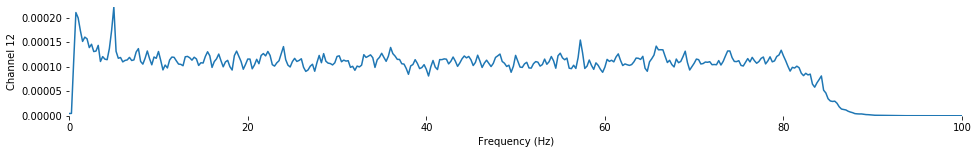

In [9]:
# note:
# powerline impact at 60 Hz

# check channel 12
plot_channels(data = data, x = 'freq', channel_start = 12, channel_end = 13)

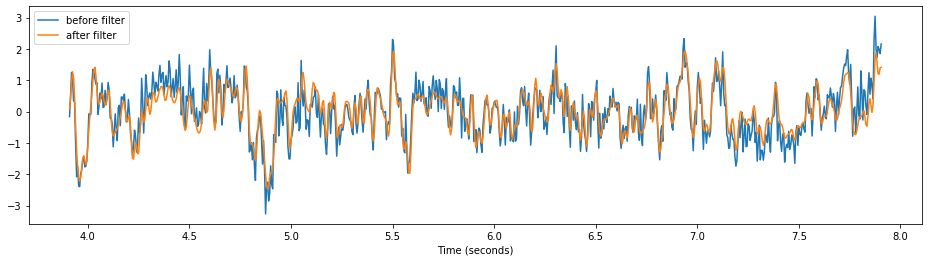

In [10]:
# "We do not expect neural activity outside of the frequency band from 1-40 Hertz"

# https://brainclinics.com/wp-content/uploads/Filtering_in_BioExplorer.pdf

# build filter
firwin_filter = signal.firwin(win, [1/sf*2, 40/sf*2], pass_zero=False)
# plt.plot(firwin_filter)
# plt.show()

# before vs after the filter
before_filter = data[:, 5]
after_filter = signal.convolve(before_filter, firwin_filter, mode='same')

plt.figure(figsize = (16, 4))
plt.xlabel('Time (seconds)') 
plt.plot(time[:win], before_filter[:win], label = 'before filter')
plt.plot(time[:win], after_filter[:win], label = 'after filter')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

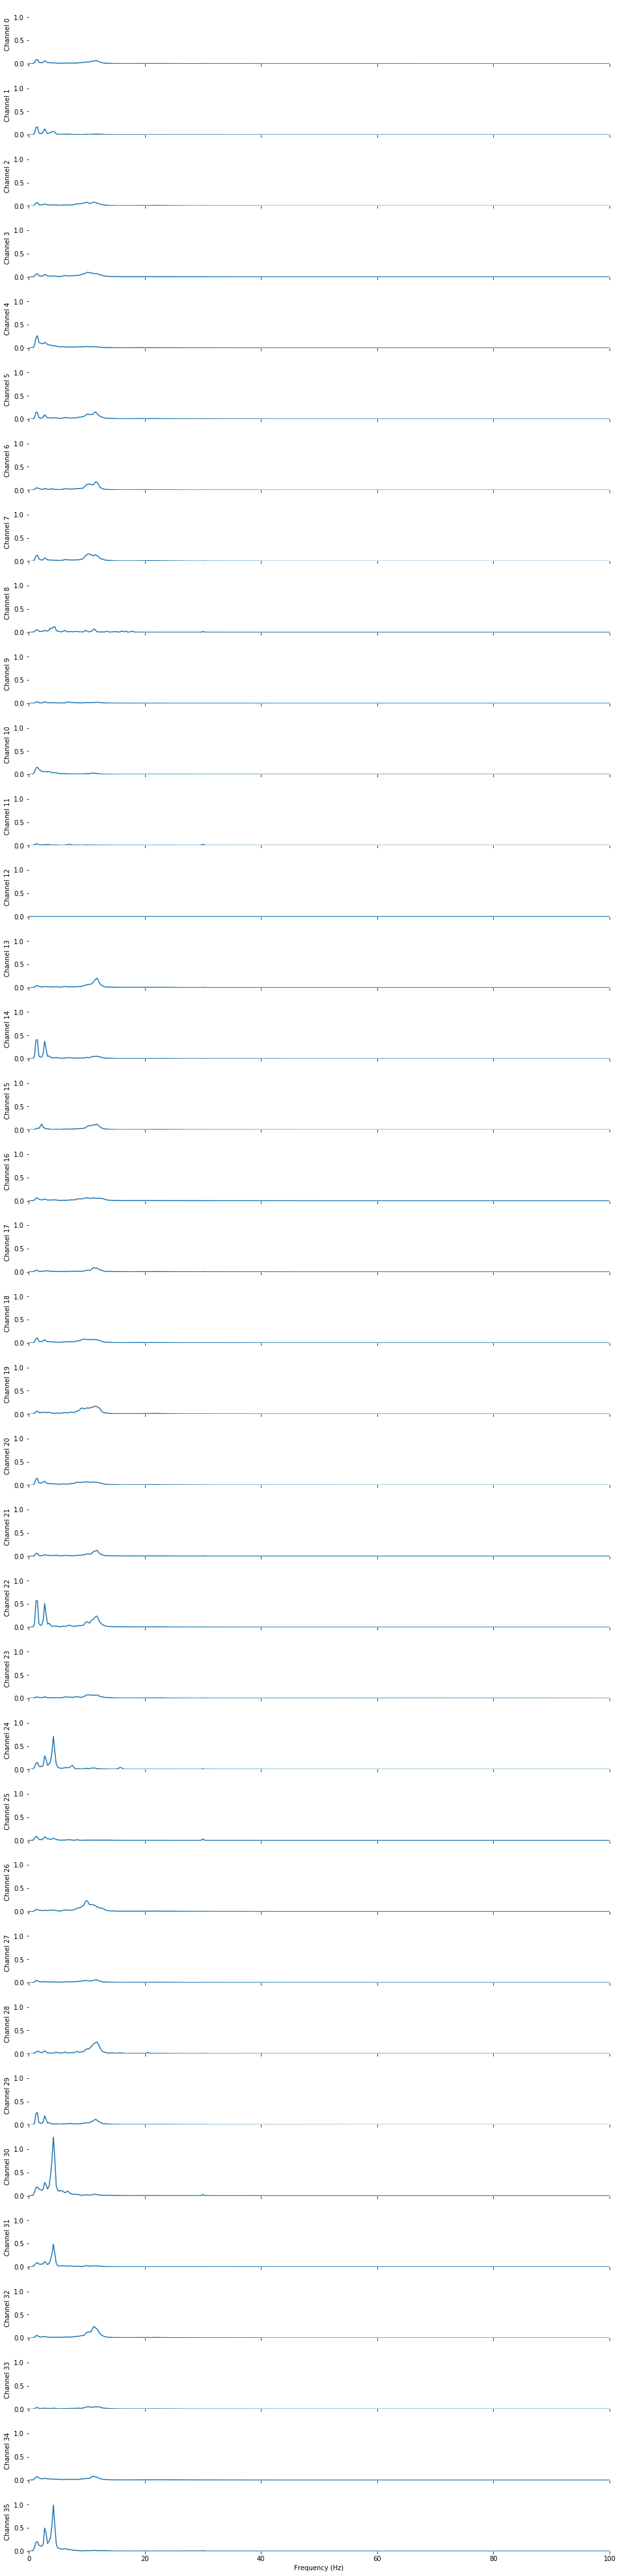

In [485]:
# apply filter to whole dataset, data -> data_af
data_af = np.ndarray((len(data), 0))
for i in range(data.shape[1]):
    data_af = np.concatenate((data_af, 
                              signal.convolve(data[:, i], firwin_filter, mode='same').reshape(len(data), 1)), 
                              axis=1)

# channel freq plot after filter
plot_channels(data = data_af, x = 'freq')

<Figure size 432x288 with 0 Axes>

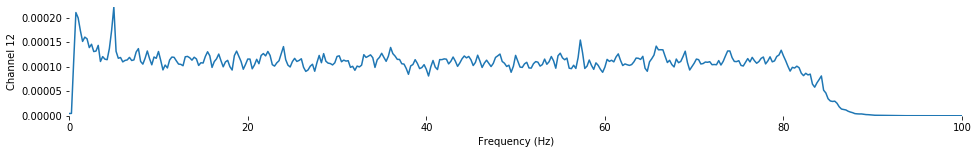

<Figure size 432x288 with 0 Axes>

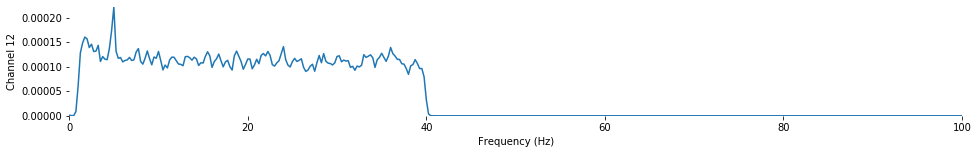

In [12]:
# check chanel 12 freq, before and after filter
plot_channels(data = data, x = 'freq', channel_start = 12, channel_end = 13)
plot_channels(data = data_af, x = 'freq', channel_start = 12, channel_end = 13)

In [17]:
# decompose brain signal - ICA
from sklearn.decomposition import FastICA, PCA
ica = FastICA(n_components = 20)
components = ica.fit_transform(data_af)  # decompose signal into components
components.shape

In [13]:
# note:
# ran once and saved components as components_v1
# components_v1 = components # keep a copy of components
# pd.DataFrame(components_v1).to_csv(os.path.join(DATA_PATH, 'components_v1'), index = False)
components = pd.read_csv(os.path.join(DATA_PATH, 'components_v1')).values

<Figure size 432x288 with 0 Axes>

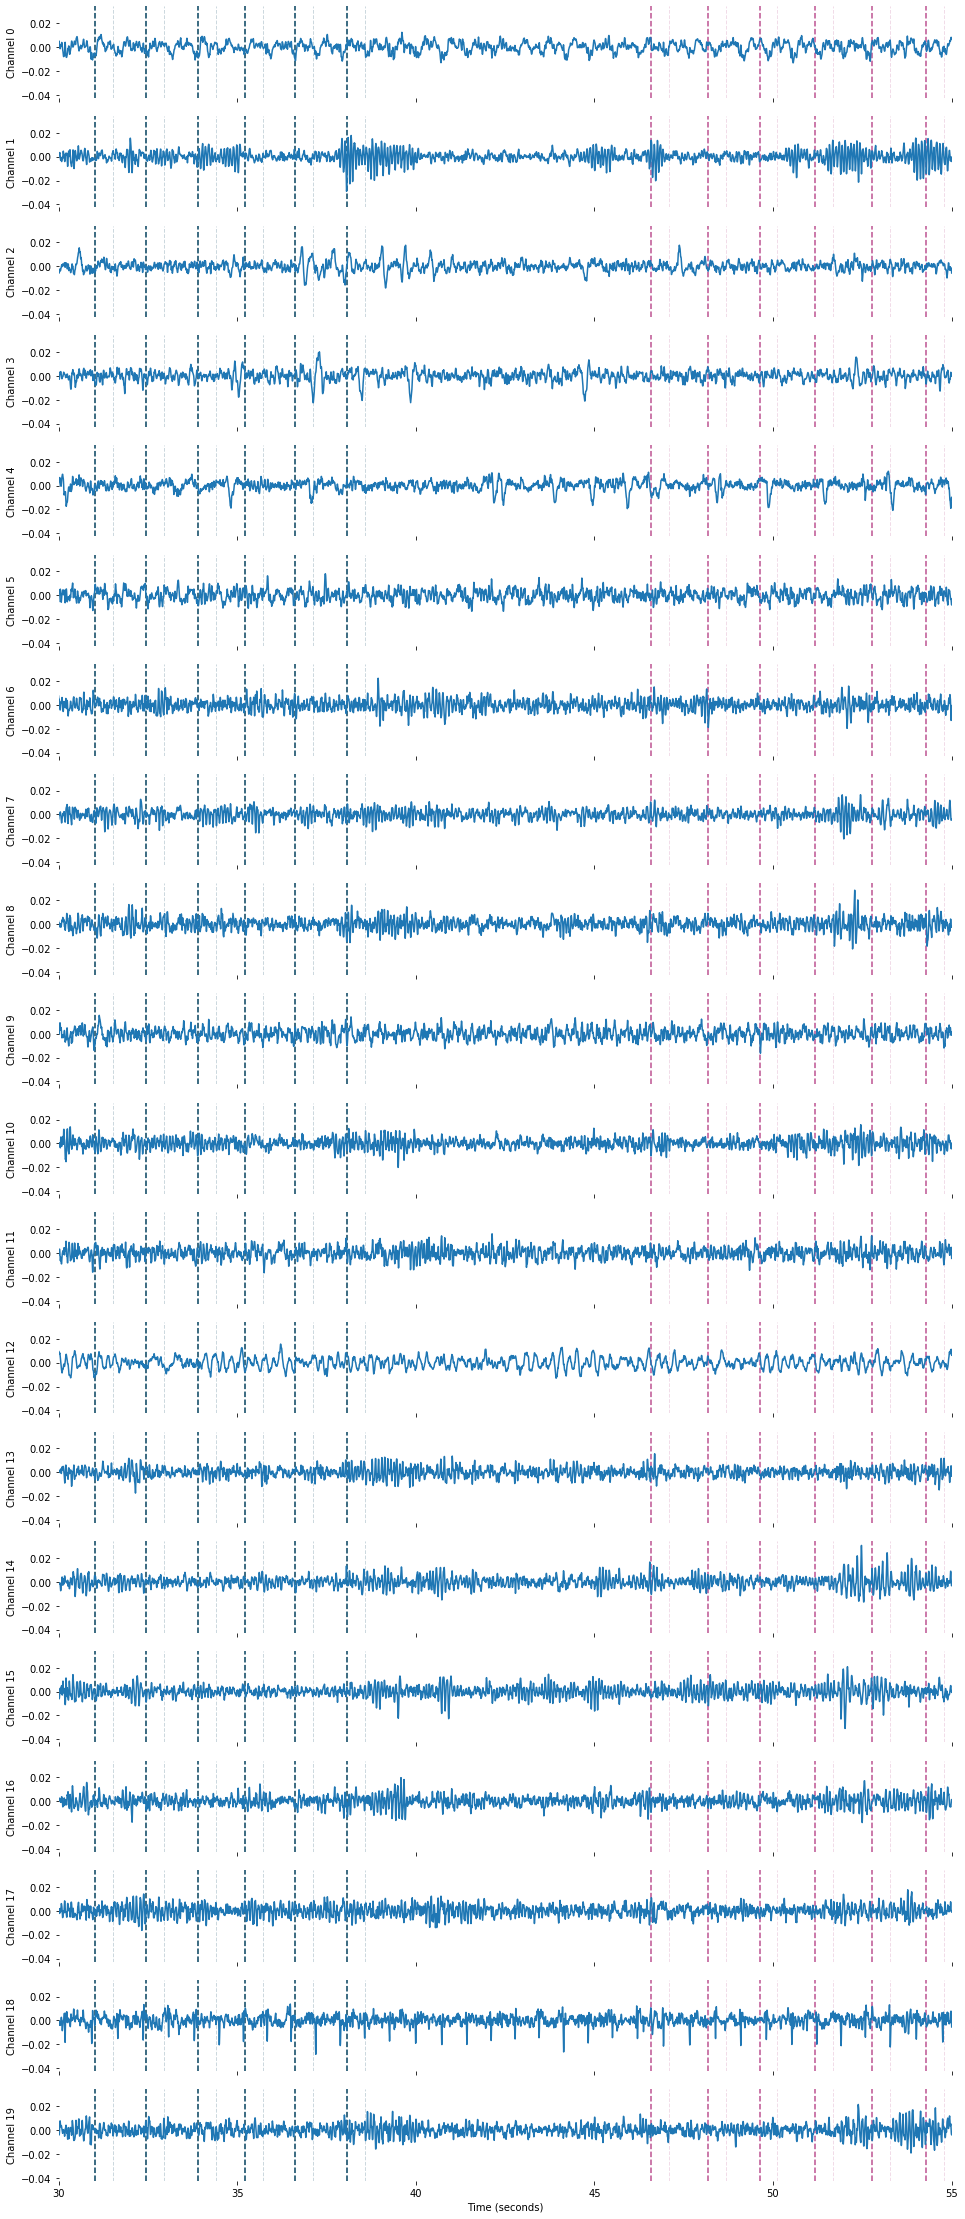

In [14]:
# plot ICA components - time
# note:
# reason of choosing window of 30 ~ 50 secs
# 1. has a stimulus window (no stimulus for a while)
# 2. can see both visual and auditory stimulus
plot_channels(data = components, 
              x = 'time', 
              channel_start = 0, channel_end = 20, # 20 components, NOT 36
              time_start = 30, time_end = 55, 
              vline = True)

<Figure size 432x288 with 0 Axes>

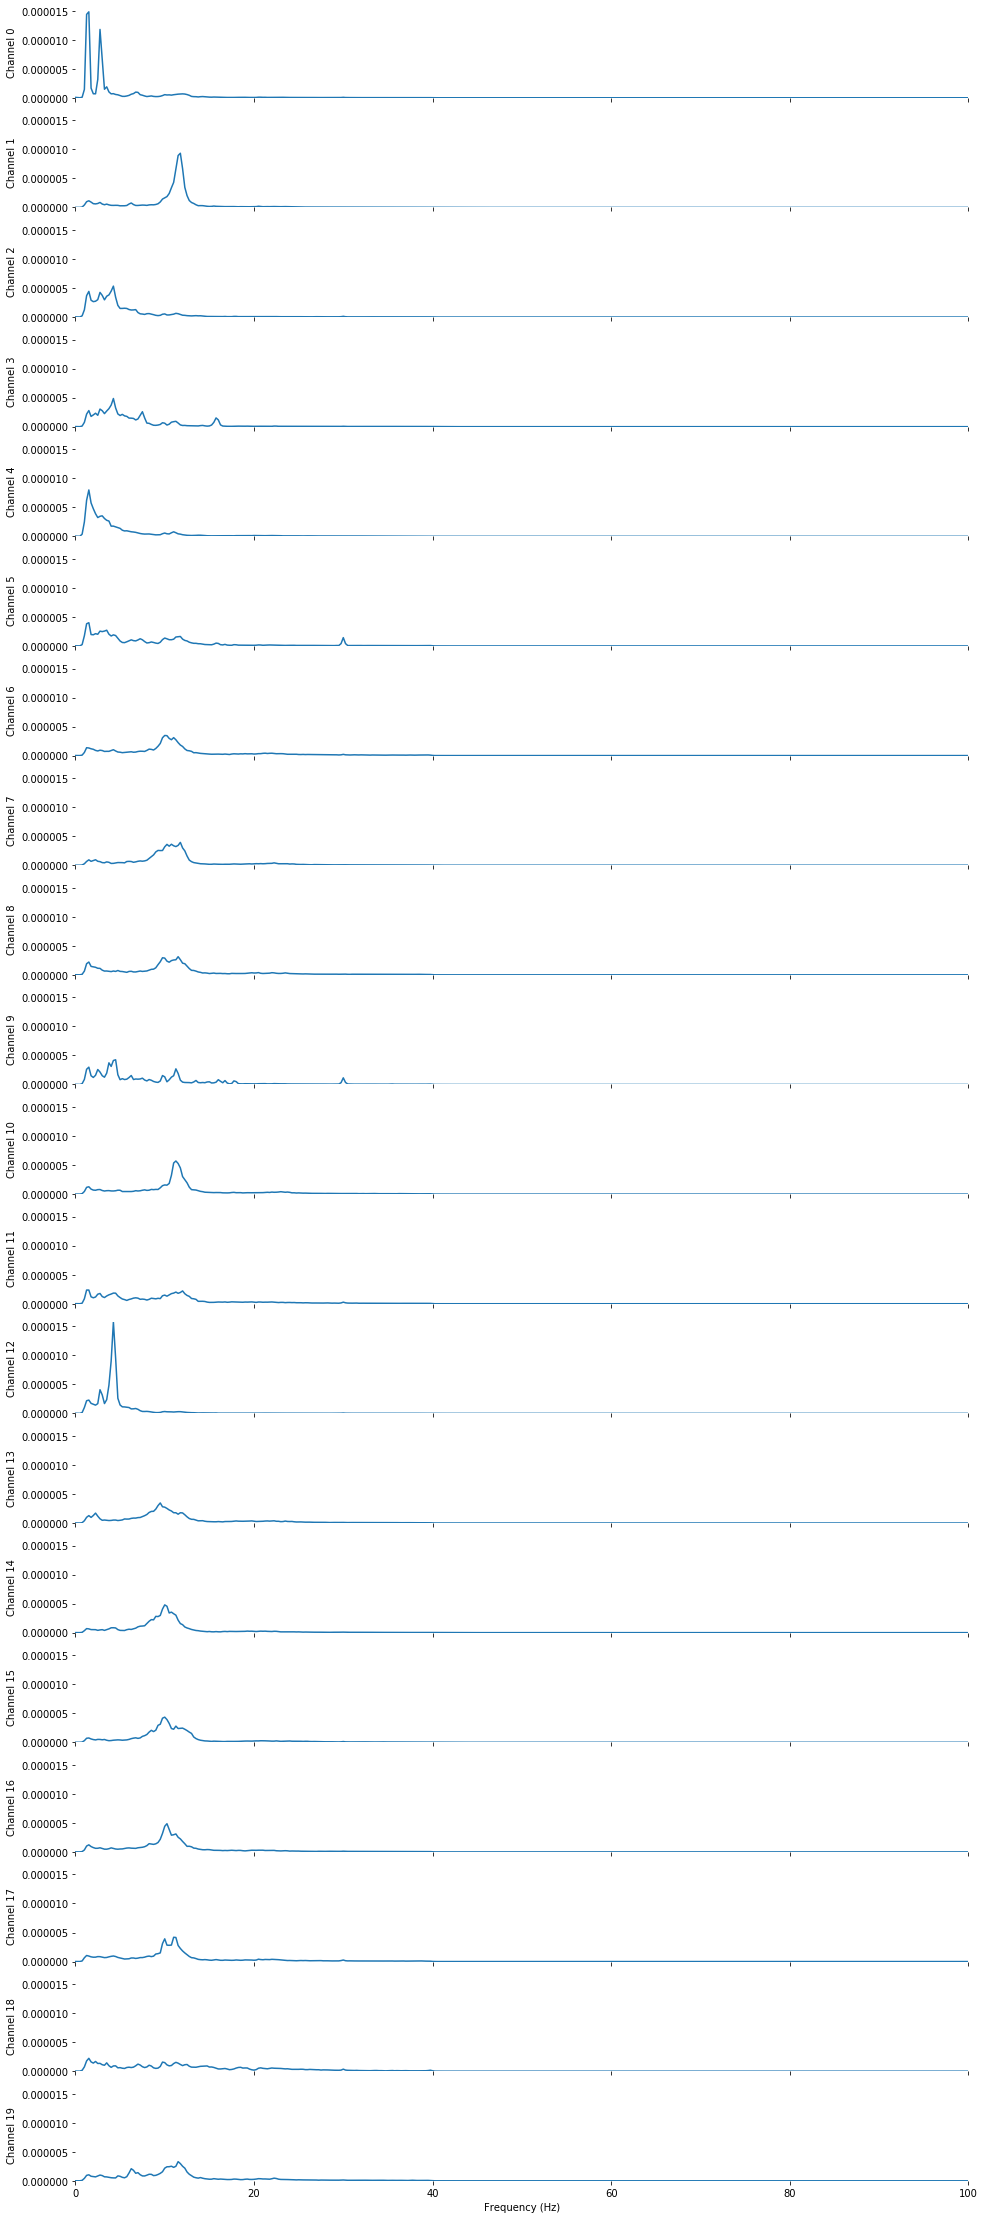

In [15]:
# plot ICA components - freq
plot_channels(data = components, 
              x = 'freq', 
              channel_start = 0, channel_end = 20) # 20 components

In [22]:
# remove "pulse"
# component 0, 18 - heart beat? (both have 12.5 "pulse" between the stimulus window of ~8.5 sec)

In [23]:
# remove blink/eye activity
# need location or EOG info!

# https://www.researchgate.net/figure/The-frequency-response-of-eye-blinking-signal_fig4_275830679
# https://www.researchgate.net/figure/Proposed-algorithm-for-eye-blinking-extraction_fig5_275830679

# component 2*, 3*, 4

In [24]:
# remove muscle activity
# component 5, 9 - activity > 20 Hz; no alpha peak; no obvious response to stimulus?

In [25]:
# remove other activity
# component 12

In [16]:
# remove unwanted activities
remove_indices = [0, 2, 3, 4, 5, 9, 12, 18]
components[:, remove_indices] = 0

In [18]:
# reconstruct data, data_af + components -> data_final
data_final = ica.inverse_transform(components)
# save a copy of final data
# pd.DataFrame(data_final).to_csv(os.path.join(DATA_PATH, 'data_final'), index = False)
# data_final = pd.read_csv(os.path.join(DATA_PATH, 'data_final')).values

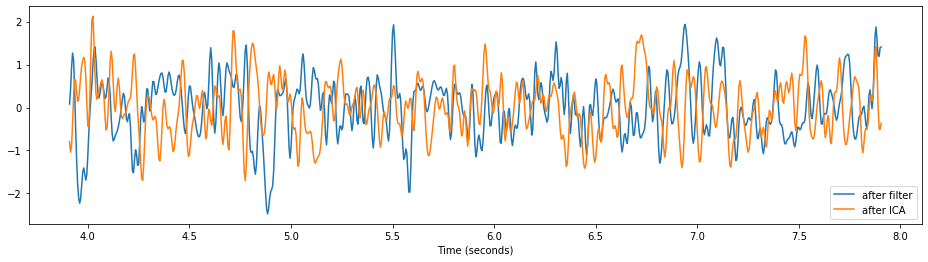

In [19]:
# check data before vs after ICA
before_filter = data[:, 5]
after_filter = signal.convolve(before_filter, firwin_filter, mode='same')
after_ica = data_final[:, 5]

plt.figure(figsize = (16, 4))
plt.xlabel('Time (seconds)') 
#plt.plot(time[:win], before_filter[:win], label = 'orig')
plt.plot(time[:win], after_filter[:win], label = 'after filter')
plt.plot(time[:win], after_ica[:win], label = 'after ICA')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

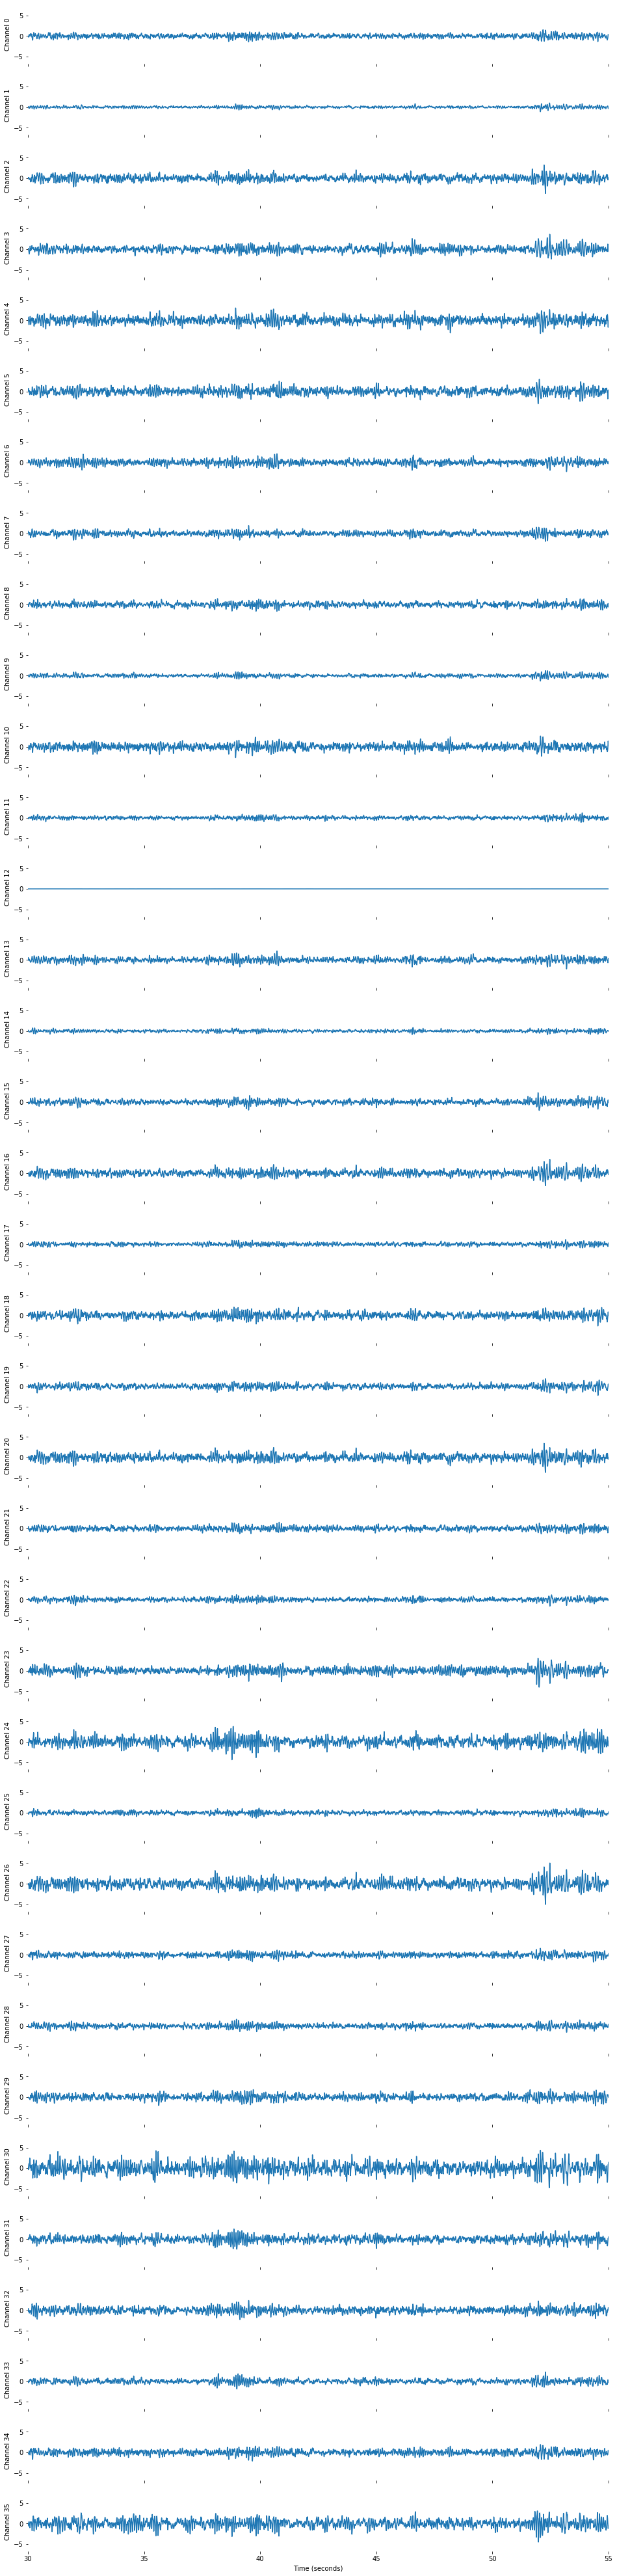

In [20]:
# data_final check - time
plot_channels(data = data_final,
              x = 'time',
              time_start = 30,
              time_end = 55)

<Figure size 432x288 with 0 Axes>

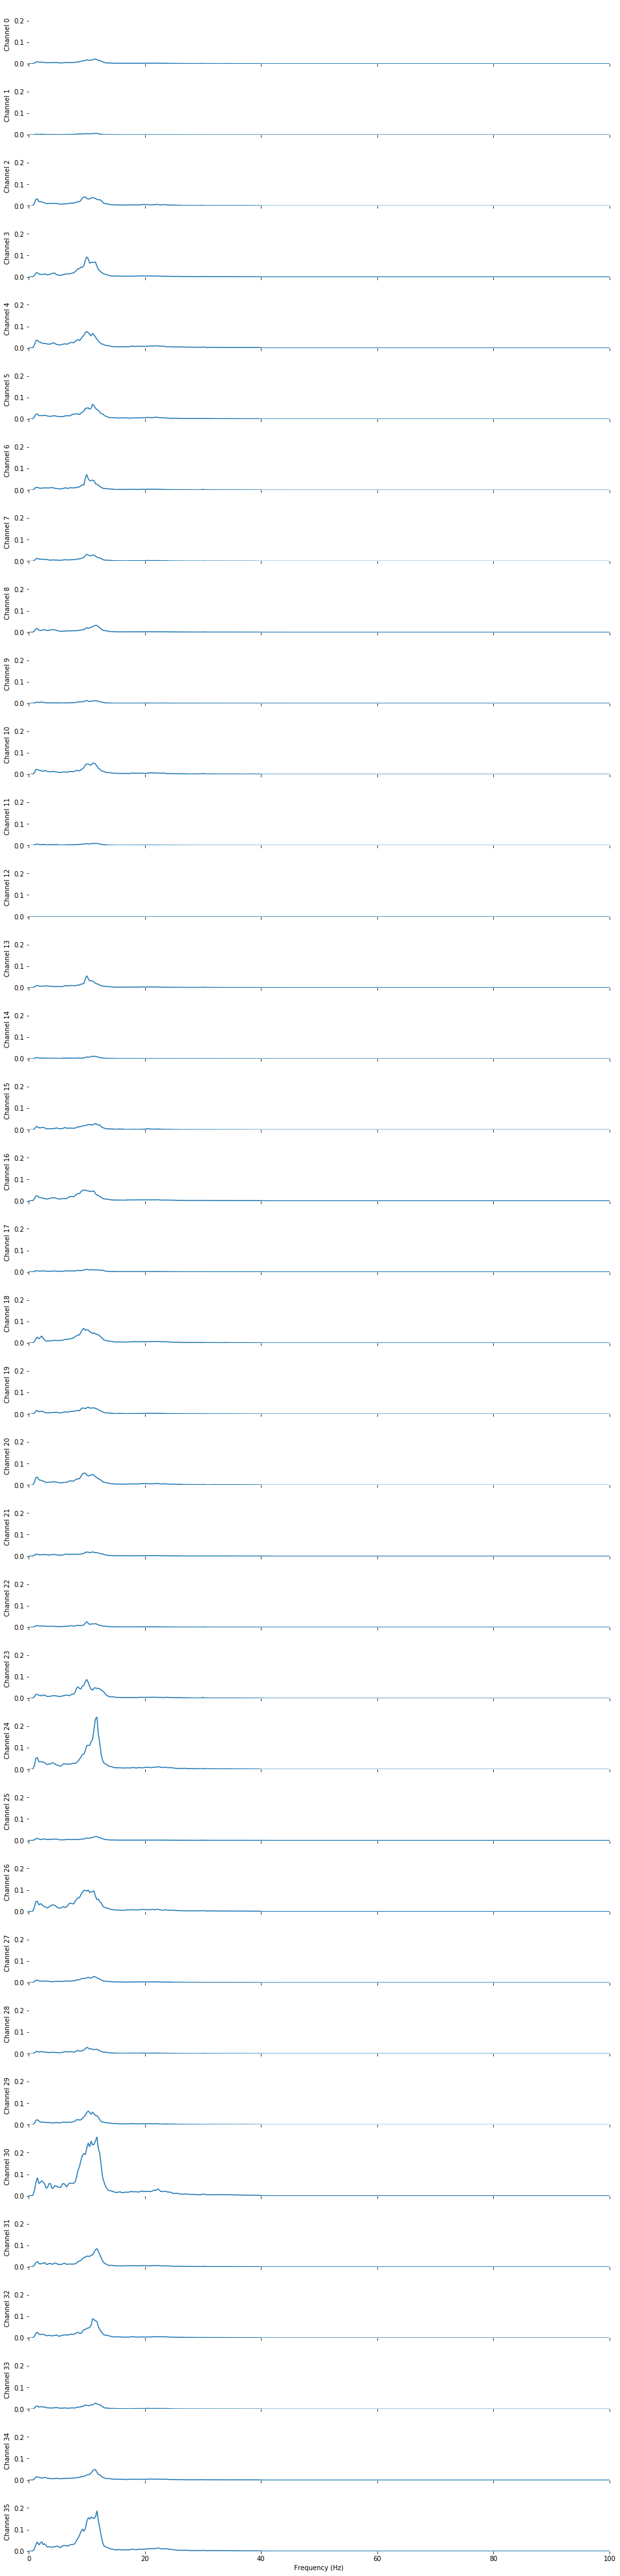

In [21]:
# data_final check - freq
plot_channels(data = data_final, x = 'freq')

<Figure size 432x288 with 0 Axes>

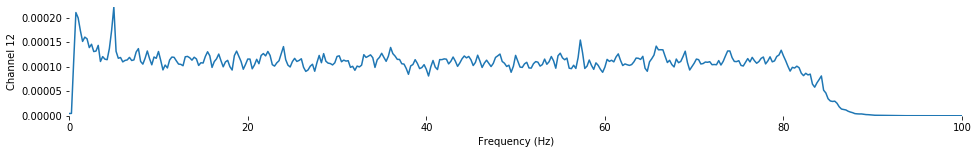

<Figure size 432x288 with 0 Axes>

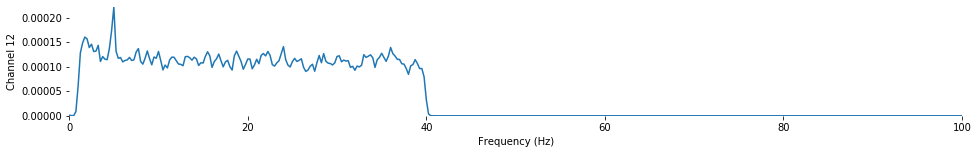

<Figure size 432x288 with 0 Axes>

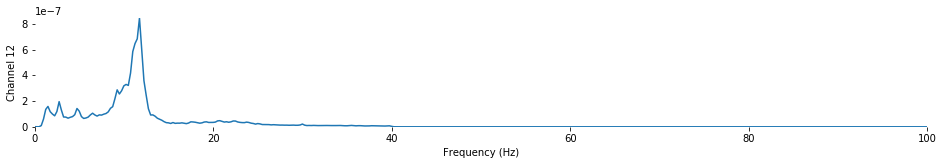

In [22]:
# chack channel 12 - freq
# ???!!!
plot_channels(data = data, x = 'freq', channel_start = 12, channel_end = 13)
plot_channels(data = data_af, x = 'freq', channel_start = 12, channel_end = 13)
plot_channels(data = data_final, x = 'freq', channel_start = 12, channel_end = 13)

In [165]:
###########################
# prepare data for learning
###########################

# create 3d-array (147 stimulus, 36 channels, 100 data points)
# maybe create a new datastructure with pointers to save space?
n_stimulus = 147 # number of stimulus
n_length = 100 # 0.5 sec * 200 sample/sec
n_features = 36

# X = np.ndarray((100, 36, 0)) # -> (100, 36, 147)
# X = np.ndarray((0, 36, 100)) # -> (147, 36, 100)
X = np.ndarray((0, 100, 36)) # -> (147, 100, 36)
data_final_w_time = np.concatenate((time.reshape(len(data), 1), data_final), axis=1)
for timestamp in timestamps['timestamp']:
    for t in data_final_w_time[:, 0]:
        if timestamp - t < 1/200 and timestamp - t >= 0:
            idx = np.argwhere(data_final_w_time[:, 0] == t)
            # X = np.dstack((X, data_final_w_time[:, 1:][idx[0][0] : idx[0][0] + 100]))
            # X = np.vstack((X, data_final_w_time[:, 1:][idx[0][0] : idx[0][0] + 100].T[None]))
            X = np.vstack((X, data_final_w_time[:, 1:][idx[0][0] : idx[0][0] + 100][None]))

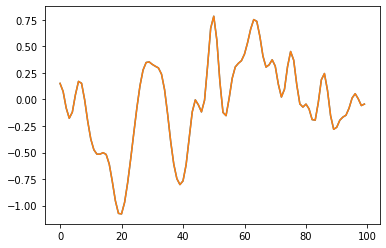

In [166]:
# check the first 100 samples
plt.plot(X[0,:,0])
plt.plot(data_final[:100, 0])

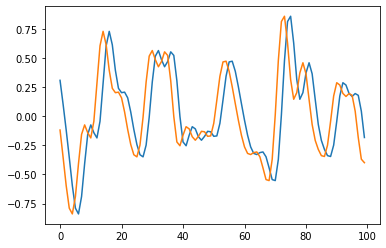

In [167]:
# check the last 100 samples
# small shift
# end_point = math.ceil((timestamps.iloc[-1]['timestamp'] + 0.5) * sf) # round up
plt.plot(X[146,:,0])
plt.plot(data_final[-100:, 0])

In [168]:
# create target vector
y = pd.get_dummies(timestamps['stimulus_type'], drop_first = True).values

In [27]:
#####################
# supervised learning
#####################
# scale?
# tensorflow 2.X
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

split = 0.2
seed = 42
n_epoches = 20

early_stop = EarlyStopping(monitor='val_loss', patience=2)

def model_evaluate(model):
    predictions = model.predict_classes(X_test)
    print('confusion matrix:\n')
    print(confusion_matrix(predictions, y_test))
    print('\n')
    print('classification report:\n')
    print(classification_report(predictions, y_test))
    metrics = pd.DataFrame(model.history.history)
    print('\n')
    print('loss and accuracy plot:\n')
    metrics[['loss', 'val_loss']].plot()
    metrics[['accuracy', 'val_accuracy']].plot()
    plt.show()

In [175]:
#################
# approach 1: cnn
#################
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten
model_cnn = Sequential()
# (batch, 100, 36) -> (batch, 50, 72)
model_cnn.add(Conv1D(filters=72, kernel_size=2, activation='relu', input_shape=(n_length, n_features)))
model_cnn.add(MaxPool1D(pool_size=2))
# (batch, 50, 72) -> (batch, 25, 144)
model_cnn.add(Conv1D(filters=144, kernel_size=2, activation='relu'))
model_cnn.add(MaxPool1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid')) # output layer
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=seed)
model_cnn.fit(X_train, y_train, epochs=n_epochs, validation_data=(X_test,y_test), callbacks=[early_stop])

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_74 (Conv1D)           (None, 99, 72)            5256      
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 49, 72)            0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 48, 144)           20880     
_________________________________________________________________
max_pooling1d_72 (MaxPooling (None, 24, 144)           0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 3456)              0         
_________________________________________________________________
dense_69 (Dense)             (None, 100)               345700    
_________________________________________________________________
dense_70 (Dense)             (None, 1)               

confusion matrix:

[[15  3]
 [ 0 12]]


classification report:

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        18
           1       0.80      1.00      0.89        12

    accuracy                           0.90        30
   macro avg       0.90      0.92      0.90        30
weighted avg       0.92      0.90      0.90        30



loss and accuracy plot:



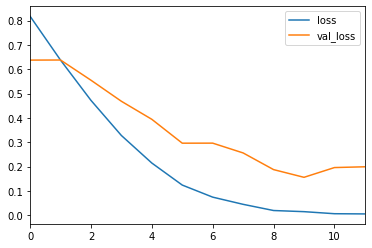

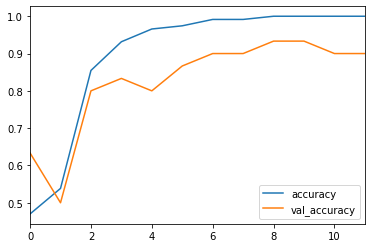

In [209]:
model_evaluate(model_cnn)

In [235]:
#####################
# approach 2 cnn-lstm
#####################
# ConvLSTM2D if have location info?
from tensorflow.keras.layers import LSTM, TimeDistributed#, RepeatVector, Reshape
# reshape data into stimulus of sub-sequences (eg. 4 * 25 = 100)
n_sub_sequences = 1
n_sub_length = int(n_length / n_sub_sequences)
X_train = X_train.reshape((X_train.shape[0], n_sub_sequences, n_sub_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_sub_sequences, n_sub_length, n_features))

model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=72, kernel_size=2, activation='relu'), input_shape=(None, n_sub_length, n_features)))
model_cnn_lstm.add(TimeDistributed(MaxPool1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=144, kernel_size=2, activation='relu')))
model_cnn_lstm.add(TimeDistributed(MaxPool1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(100))
model_cnn_lstm.add(Dense(100, activation='relu'))
model_cnn_lstm.add(Dense(1, activation='sigmoid'))
model_cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_lstm.summary()

model_cnn_lstm.fit(X_train, y_train, epochs=n_epochs, validation_data=(X_test,y_test), callbacks=[early_stop])

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_185 (TimeDi (None, None, 99, 72)      5256      
_________________________________________________________________
time_distributed_186 (TimeDi (None, None, 49, 72)      0         
_________________________________________________________________
time_distributed_187 (TimeDi (None, None, 48, 144)     20880     
_________________________________________________________________
time_distributed_188 (TimeDi (None, None, 24, 144)     0         
_________________________________________________________________
time_distributed_189 (TimeDi (None, None, 3456)        0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 100)               1422800   
_________________________________________________________________
dense_226 (Dense)            (None, 100)             

confusion matrix:

[[14  0]
 [ 1 15]]


classification report:

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.94      0.97        16

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



loss and accuracy plot:



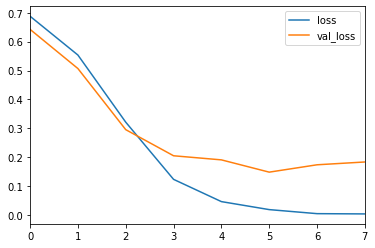

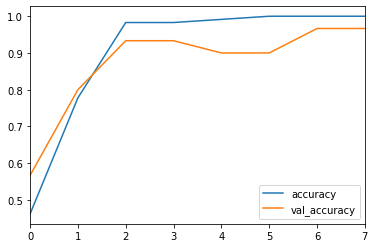

In [236]:
model_evaluate(model_cnn_lstm)

In [72]:
#######################
# unsupervised learning
#######################

##################################
# autoencoder - TEST, DOESN'T WORK
##################################
# code size too small?
from tensorflow.keras.layers import Reshape
from tensorflow.keras.optimizers import SGD

encoder = Sequential()
encoder.add(Flatten(input_shape=[n_length, n_features]))
encoder.add(Dense(1800, activation='tanh'))
encoder.add(Dense(900, activation='tanh'))
encoder.add(Dense(450, activation='tanh'))
encoder.add(Dense(225, activation='tanh'))
encoder.add(Dense(147, activation='tanh'))
# encoder.add(Dense(900, activation='relu'))
# encoder.add(Dense(225, activation='relu'))
# encoder.add(Dense(56, activation='relu'))
# encoder.add(Dense(8, activation='relu'))
# encoder.add(Dense(2, activation='relu'))

decoder = Sequential()
# decoder.add(Dense(8, input_shape=[2], activation='relu'))
# decoder.add(Dense(56, input_shape=[8], activation='relu'))
# decoder.add(Dense(225, input_shape=[56], activation='relu'))
# decoder.add(Dense(900, input_shape=[225], activation='relu'))
decoder.add(Dense(225, input_shape=[147], activation='tanh'))
decoder.add(Dense(450, activation='tanh'))
decoder.add(Dense(900, activation='tanh'))
decoder.add(Dense(1800, activation='tanh'))
decoder.add(Dense(3600, activation='sigmoid'))
decoder.add(Reshape([n_length, n_features]))

autoencoder = Sequential([encoder, decoder])

autoencoder.summary()
autoencoder.compile(loss='mse', optimizer=SGD(learning_rate=10), metrics=['accuracy'])

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_35 (Sequential)   (None, 147)               8642847   
_________________________________________________________________
sequential_36 (Sequential)   (None, 100, 36)           8646300   
Total params: 17,289,147
Trainable params: 17,289,147
Non-trainable params: 0
_________________________________________________________________


In [449]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=seed)
autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=[X_test, X_test], callbacks=[early_stop])

Train on 117 samples, validate on 30 samples
Epoch 1/20
117/117 [==============================] - 1s 7ms/sample - loss: 0.5889 - accuracy: 0.0290 - val_loss: 0.5618 - val_accuracy: 0.0253
Epoch 2/20
117/117 [==============================] - 0s 3ms/sample - loss: 0.5496 - accuracy: 0.0453 - val_loss: 0.4811 - val_accuracy: 0.0443
Epoch 3/20
117/117 [==============================] - 0s 3ms/sample - loss: 0.4823 - accuracy: 0.0709 - val_loss: 0.4260 - val_accuracy: 0.0867
Epoch 4/20
117/117 [==============================] - 0s 3ms/sample - loss: 0.4814 - accuracy: 0.0975 - val_loss: 0.4664 - val_accuracy: 0.1030
Epoch 5/20
117/117 [==============================] - 0s 3ms/sample - loss: 0.4781 - accuracy: 0.1136 - val_loss: 0.3924 - val_accuracy: 0.1110
Epoch 6/20
117/117 [==============================] - 0s 3ms/sample - loss: 0.4191 - accuracy: 0.1268 - val_loss: 0.4193 - val_accuracy: 0.0807
Epoch 7/20
117/117 [==============================] - 0s 3ms/sample - loss: 0.4187 - accura

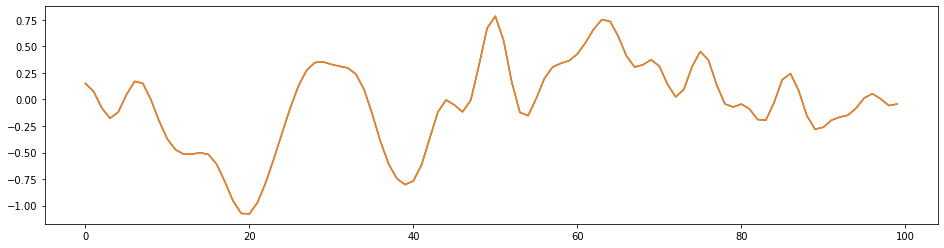

In [111]:
# dimention reduction
# combine 36 channels of 100-sample into one 3600-sample
x_reshaped = X.transpose(2, 0, 1).reshape(147, 3600) # reshape X to (147, 3600)
# x_reshaped.shape
# check reshaped data - plot stimulus 0 for channel 0
plt.figure(figsize = (16, 4))
plt.plot(X[0,:,0])
plt.plot(x_reshaped[0,:100])
plt.show()

In [91]:
# func to plot heatmap
def plot_heatmap(data):
    plt.figure(figsize = (16, 12))
    sns.heatmap(data)
    plt.show()
    
# hierarchical clustering (on correlation matrix or Kolmogorov-Smirnov matrix)
import scipy.cluster.hierarchy as sch
def plot_hierarchy(data):
    d = sch.distance.pdist(data)
    # d = sch.distance.pdist(np.nan_to_num(data))
    L = sch.linkage(d, method='ward')
    ind = sch.fcluster(L, d.max(), 'distance')
    dg = sch.dendrogram(L, no_plot=True)
    plt.figure(figsize = (16, 64))
    #sch.dendrogram(L, orientation='right', leaf_font_size=12.)
    sch.dendrogram(L, 
                   labels = [timestamps['stimulus_type'][i] for i in dg['leaves']], 
                   orientation='left', leaf_font_size=12.)
    plt.show()

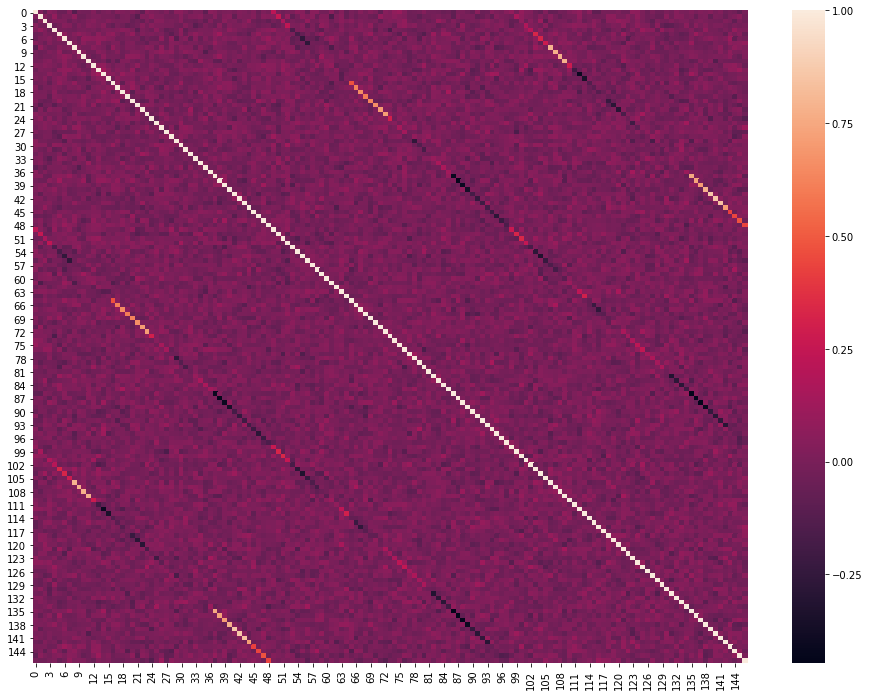

In [108]:
##################################
# pearson correlation coefficients
##################################
# scale?
plot_heatmap(np.corrcoef(x_reshaped)) # plot heatmap of correlation

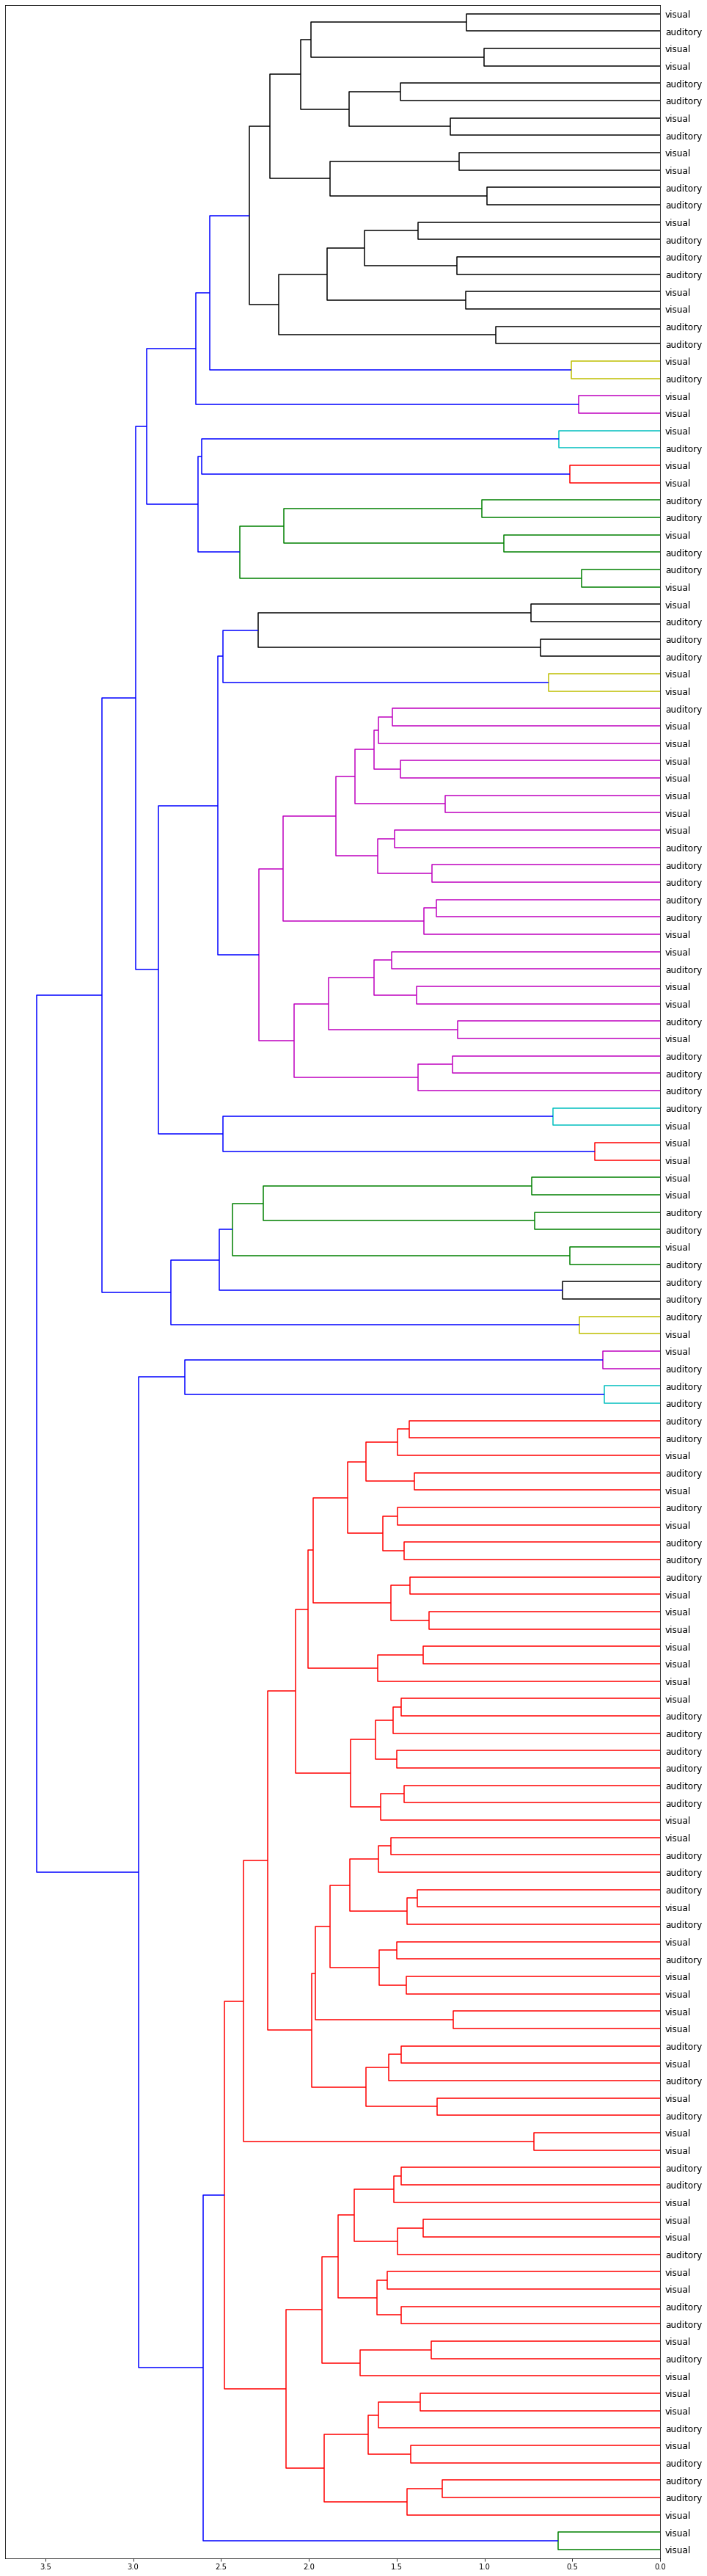

In [109]:
plot_hierarchy(np.corrcoef(x_reshaped)) # plot hierarchy of correlation

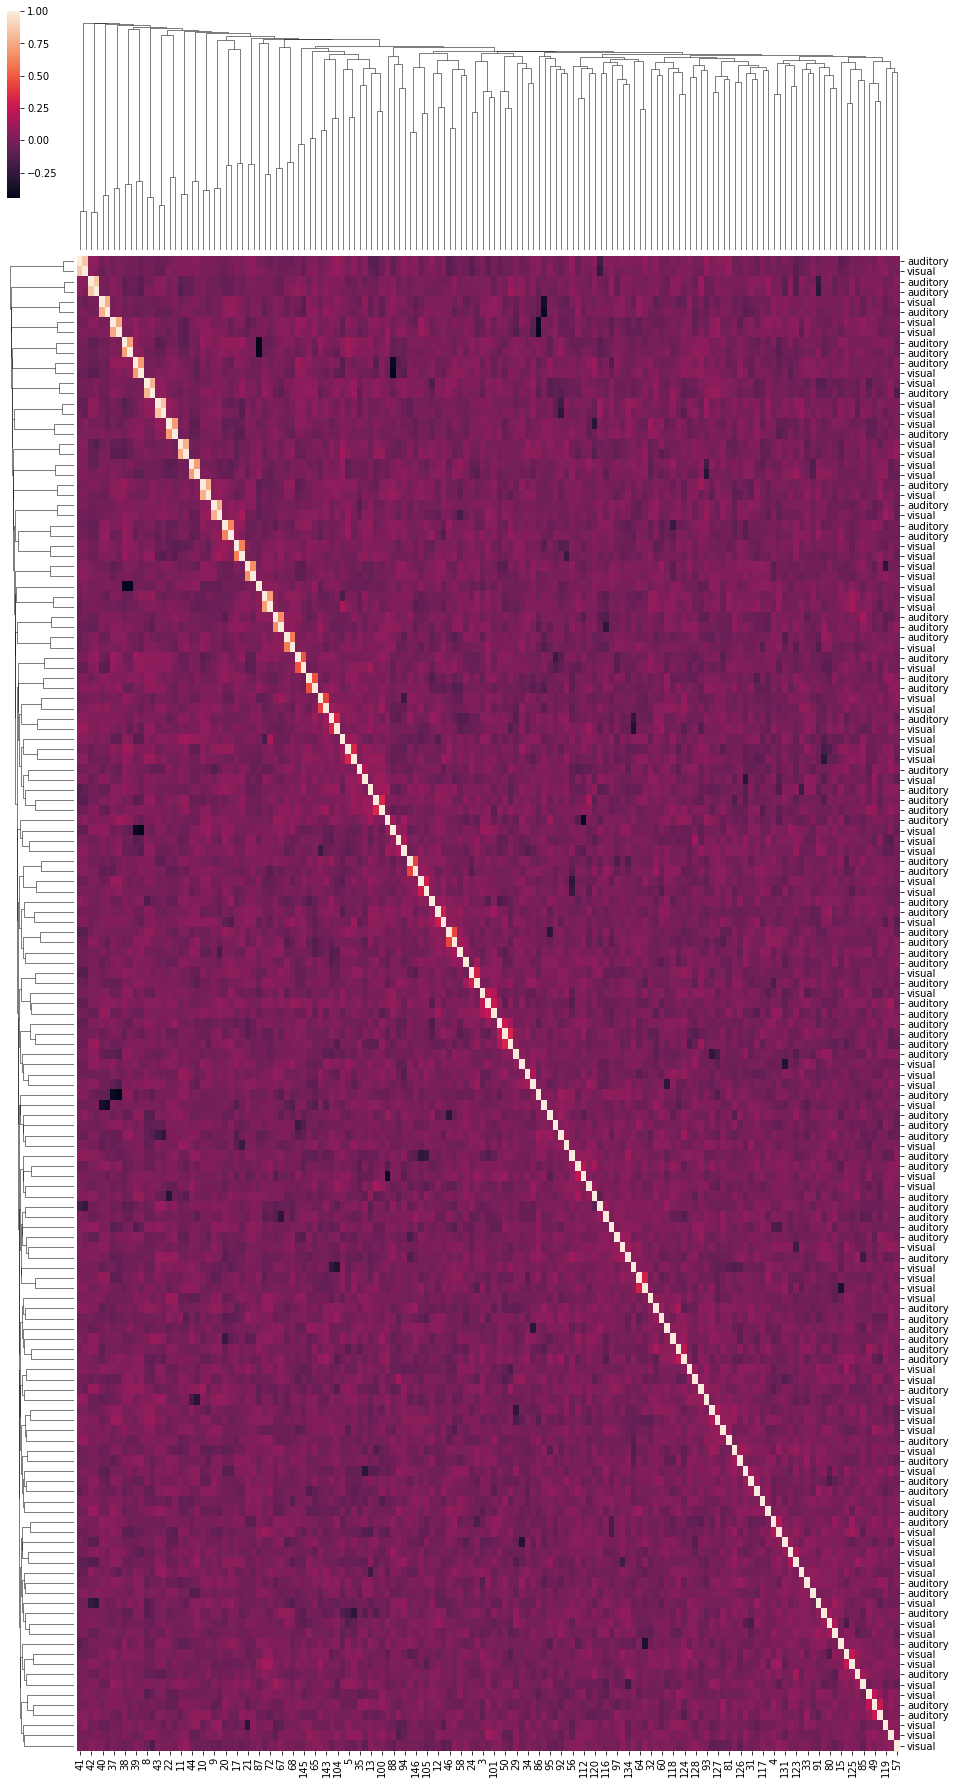

In [483]:
g = sns.clustermap(np.corrcoef(x_reshaped), 
                   figsize=(16, 32),
                   yticklabels=[timestamps['stimulus_type'][i] for i in dg['leaves']])

In [96]:
#########################
# Kolmogorov-Smirnov test
#########################
# This tests whether 2 samples are drawn from the same distribution. Note that, like in the case of the 
# one-sample K-S test, the distribution is assumed to be continuous.
# This is the two-sided test, one-sided tests are not implemented. The test uses the two-sided asymptotic 
# Kolmogorov-Smirnov distribution.
# If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the 
# distributions of the two samples are the same.
from scipy import stats

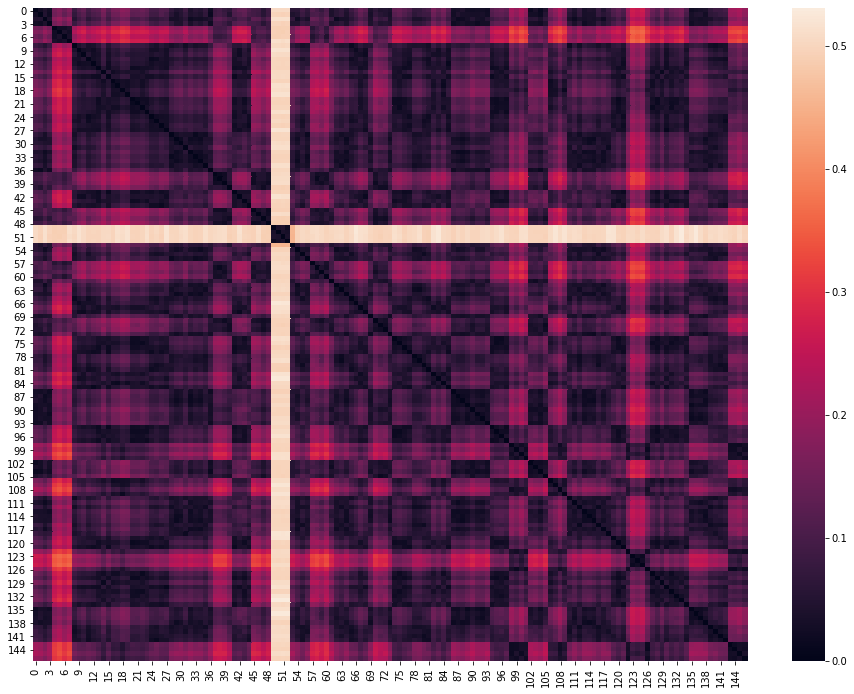

CPU times: user 39.8 s, sys: 98.6 ms, total: 39.9 s
Wall time: 39.9 s


In [113]:
%%time
# create ks correlation matrix
ks_corr = np.ndarray((147,147))
for i in range(147):
    for j in range(147):
        ks_corr[i][j] = stats.ks_2samp(x_reshaped[i], x_reshaped[j])[0]
        
plot_heatmap(ks_corr)

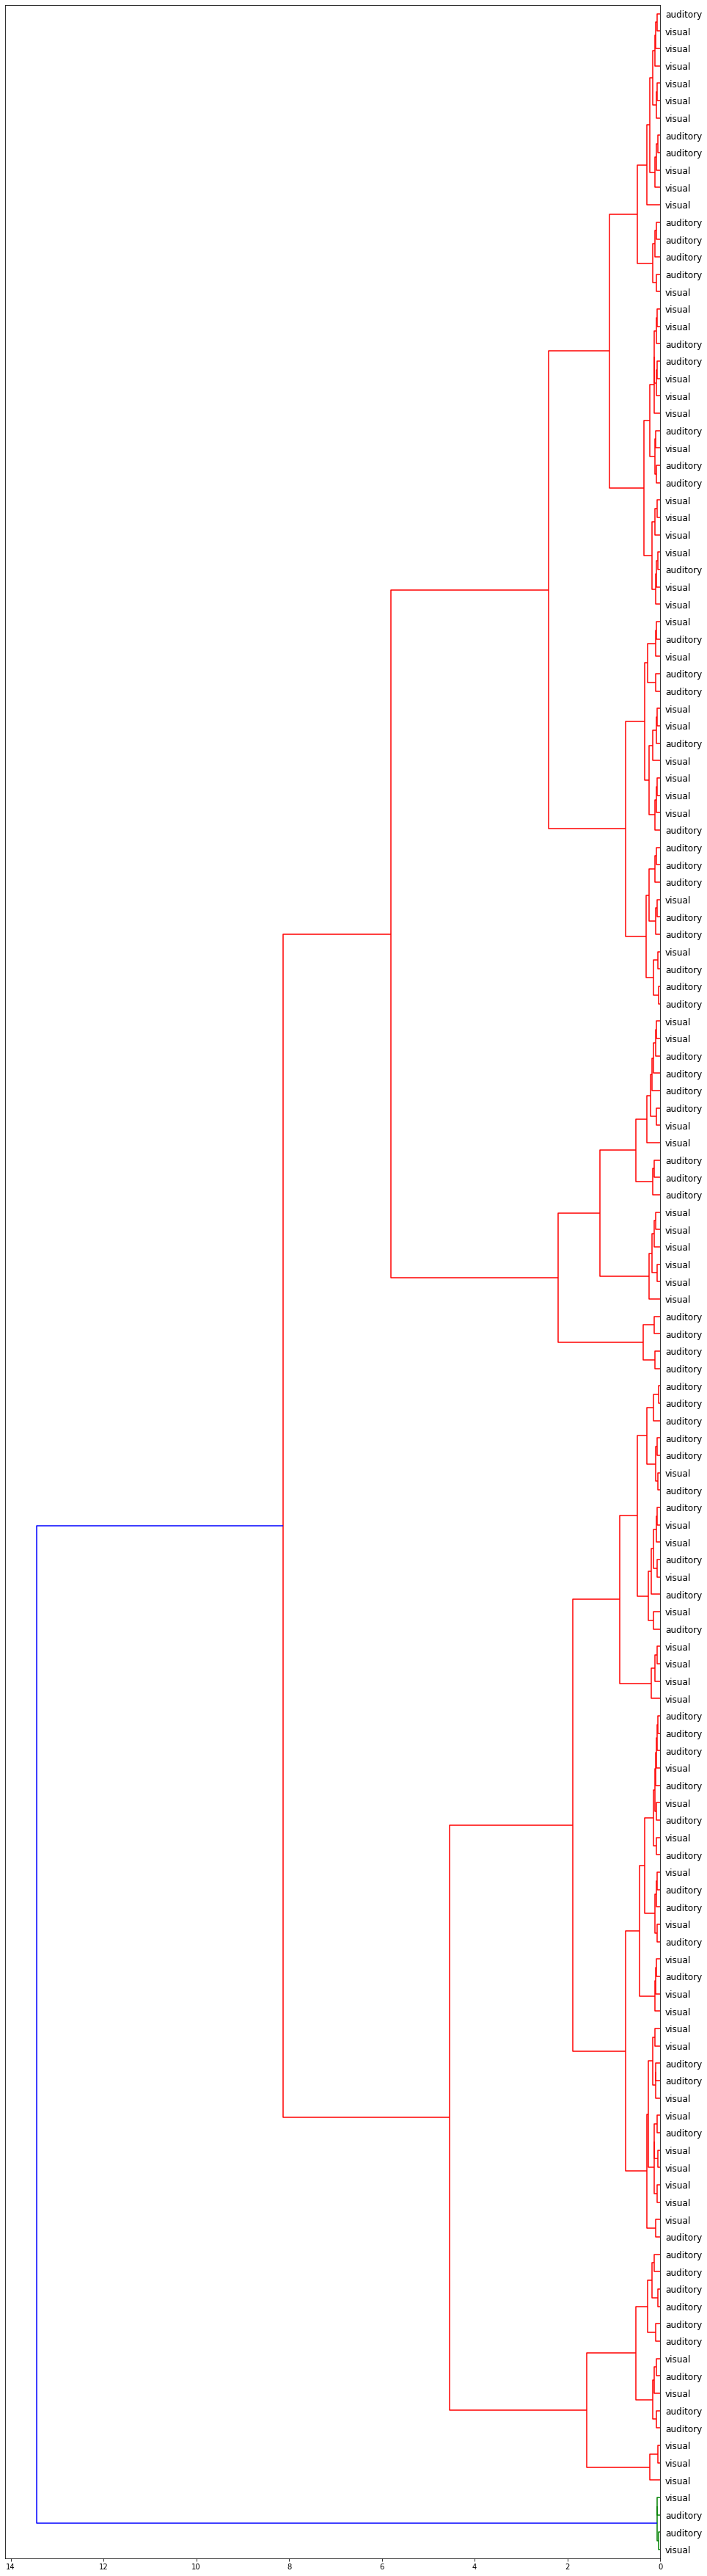

In [114]:
plot_hierarchy(ks_corr)

//anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


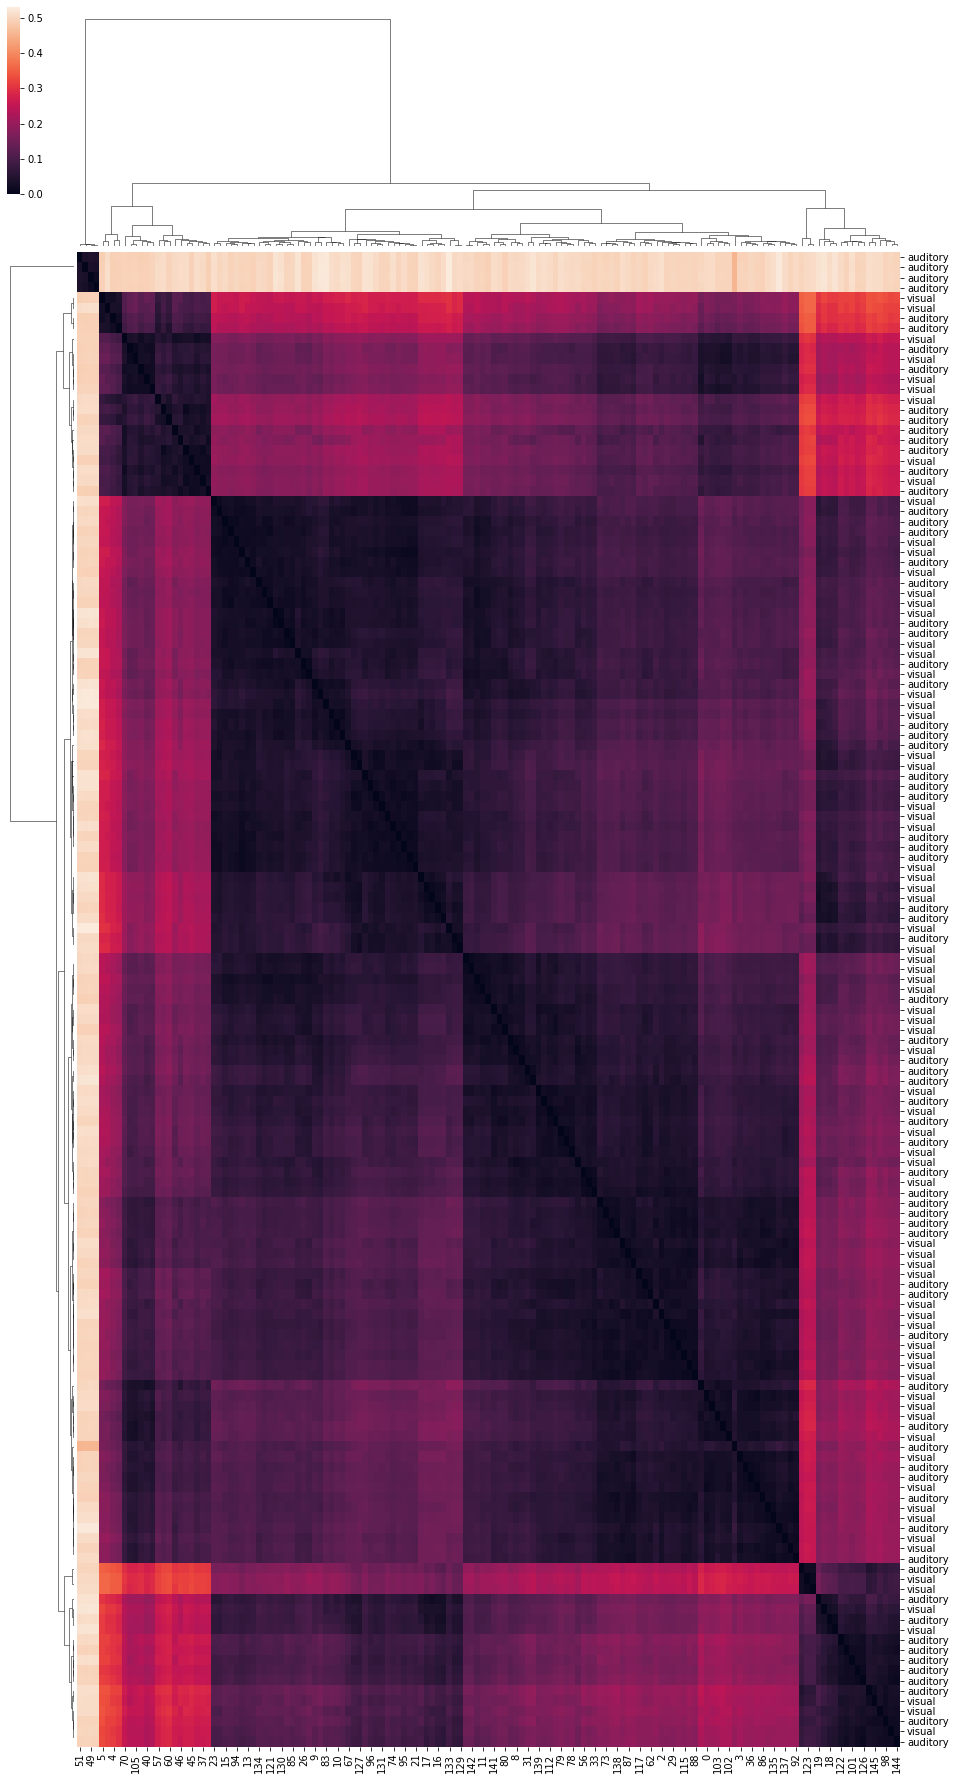

In [115]:
g = sns.clustermap(ks_corr, 
                   figsize=(16, 32),
                   yticklabels=[timestamps['stimulus_type'][i] for i in dg['leaves']])

In [116]:
#######################################################
# compress 100 sample mini series to single power point
#######################################################
from scipy.integrate import simps
power = np.ndarray((147,36))
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        freqs, psd = signal.welch(X[i,:,j], sf, nperseg=win)
        freq_res = freqs[1] - freqs[0]
        power[i][j] = simps(psd, dx=freq_res)

//anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 800 is greater than input length  = 100, using nperseg = 100
  .format(nperseg, input_length))


In [101]:
power[:,]

array([[0.21222808, 0.02632958, 0.65032672, ..., 0.19524905, 0.21399105,
        2.02705104],
       [0.12340968, 0.0158647 , 0.14540042, ..., 0.10883259, 0.12777685,
        0.7228704 ],
       [0.0891464 , 0.02718945, 0.17999172, ..., 0.07224895, 0.15228061,
        0.65261707],
       ...,
       [0.10628803, 0.02922085, 0.15773004, ..., 0.07063451, 0.11440724,
        0.78778639],
       [0.13480043, 0.07205496, 0.34690807, ..., 0.15769916, 0.18481842,
        2.03786182],
       [0.11115141, 0.04083308, 0.22334986, ..., 0.19046702, 0.07667135,
        1.69118358]])

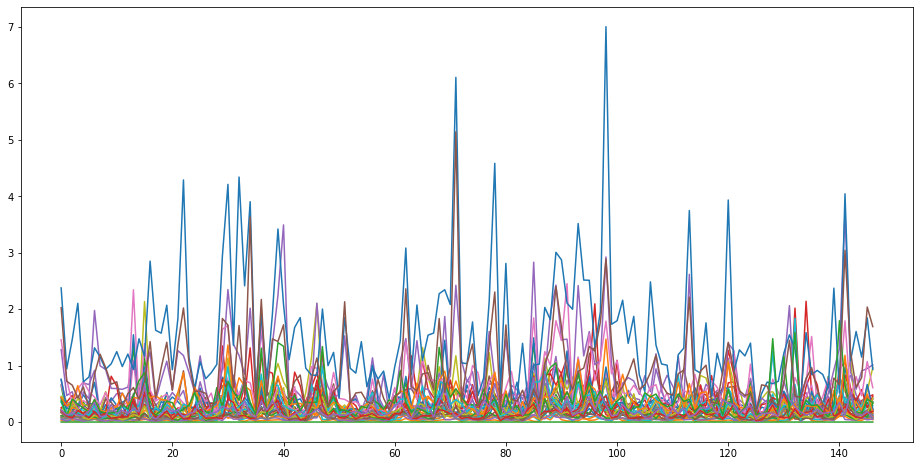

In [102]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (16, 8))
# ax = plt.axes(projection='3d')
# ax.plot(power)
plt.plot(power[:, :])
plt.show()

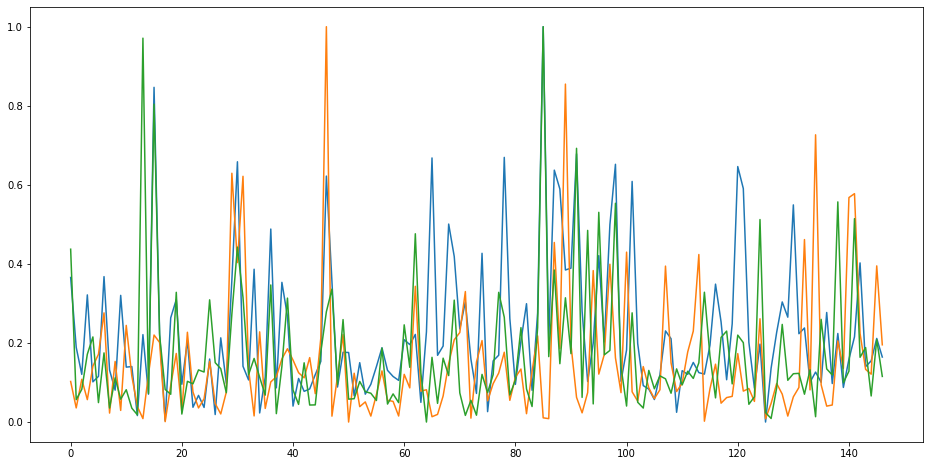

In [104]:
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
power_scaled = scaler.fit_transform(power)

fig = plt.figure(figsize = (16, 8))
plt.plot(power_scaled[:,:3])
plt.show()

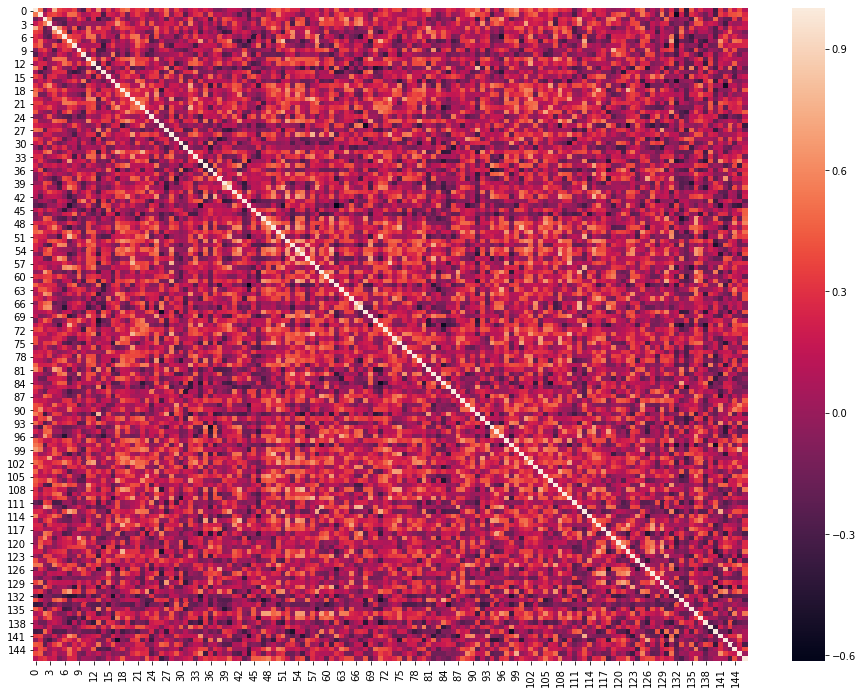

In [106]:
# pearson correlation coefficients of power
plot_heatmap(np.corrcoef(power_scaled))

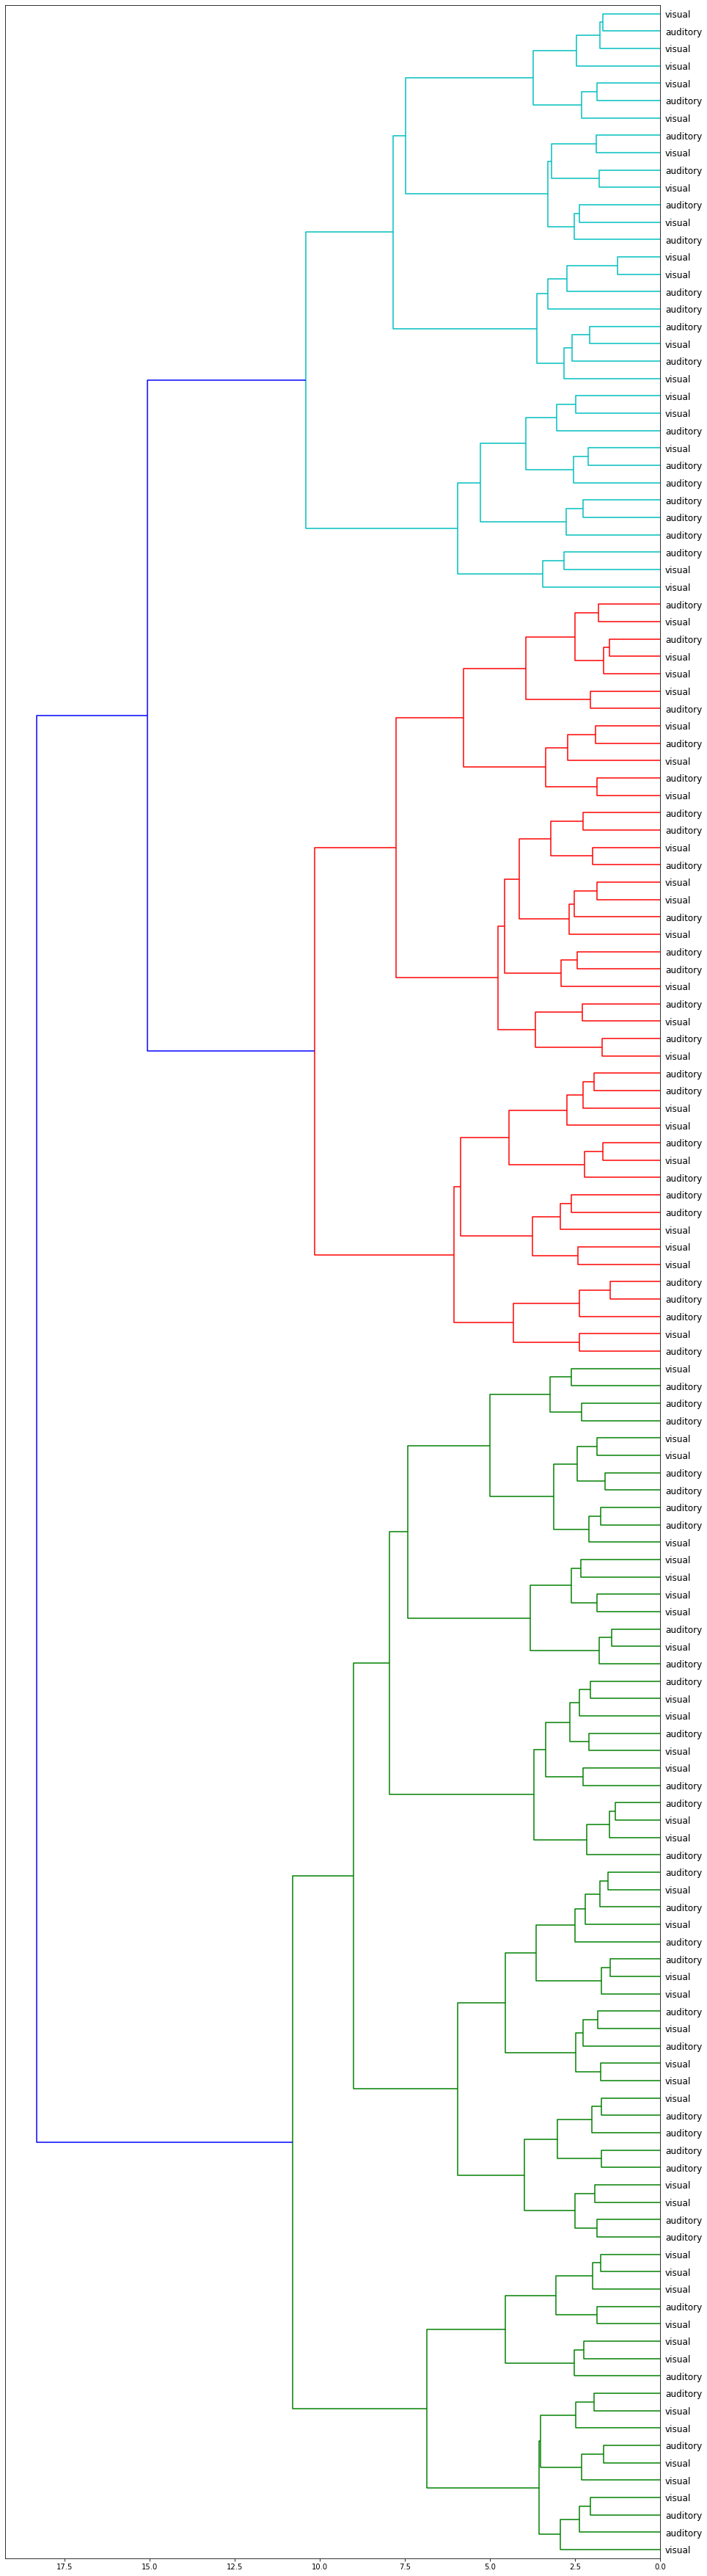

In [107]:
# hierarchical clustering on correlation matrix
plot_hierarchy(np.corrcoef(power_scaled))

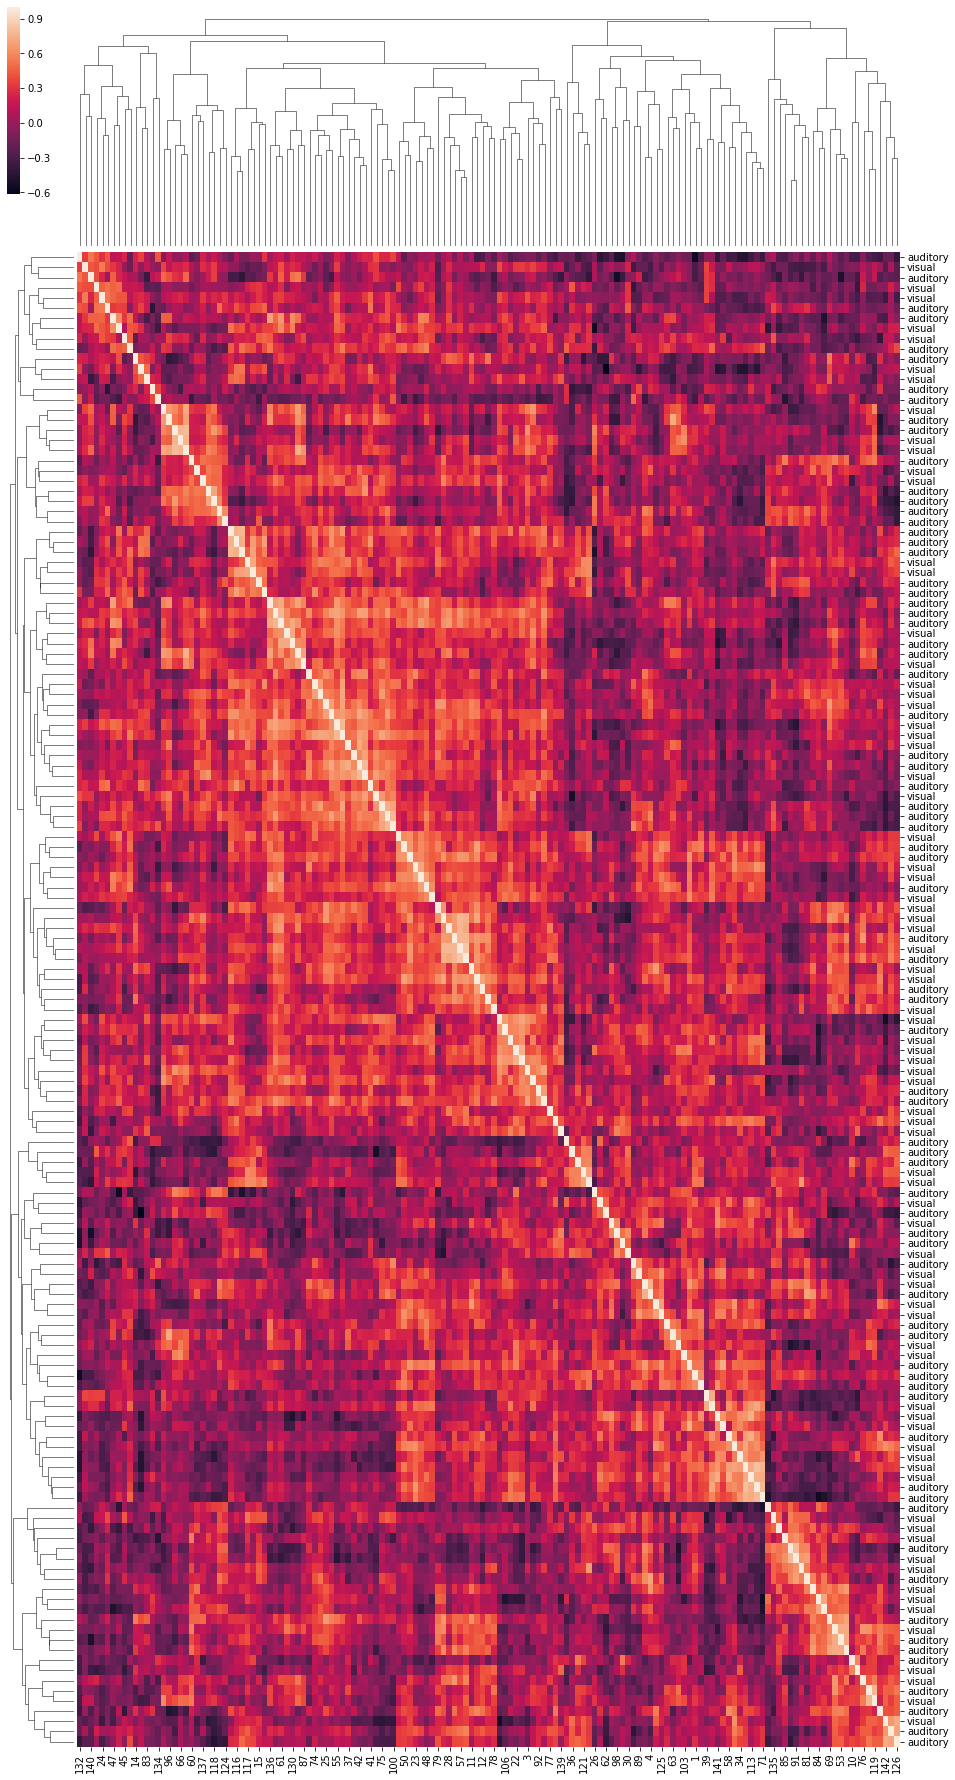

In [484]:
g = sns.clustermap(np.corrcoef(power_scaled), 
                   figsize=(16, 32),
                   yticklabels=[timestamps['stimulus_type'][i] for i in dg['leaves']])

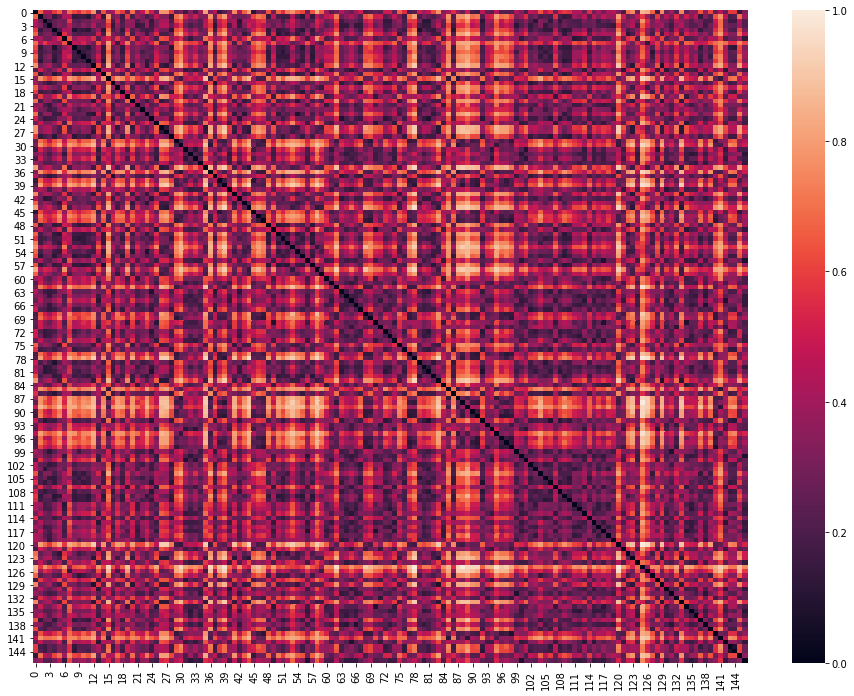

CPU times: user 1.91 s, sys: 21 ms, total: 1.93 s
Wall time: 1.94 s


In [117]:
%%time
# create ks correlation matrix
ks_corr = np.ndarray((147,147))
for i in range(147):
    for j in range(147):
        ks_corr[i][j] = stats.ks_2samp(power_scaled[i], power_scaled[j])[0]
        
plot_heatmap(ks_corr)

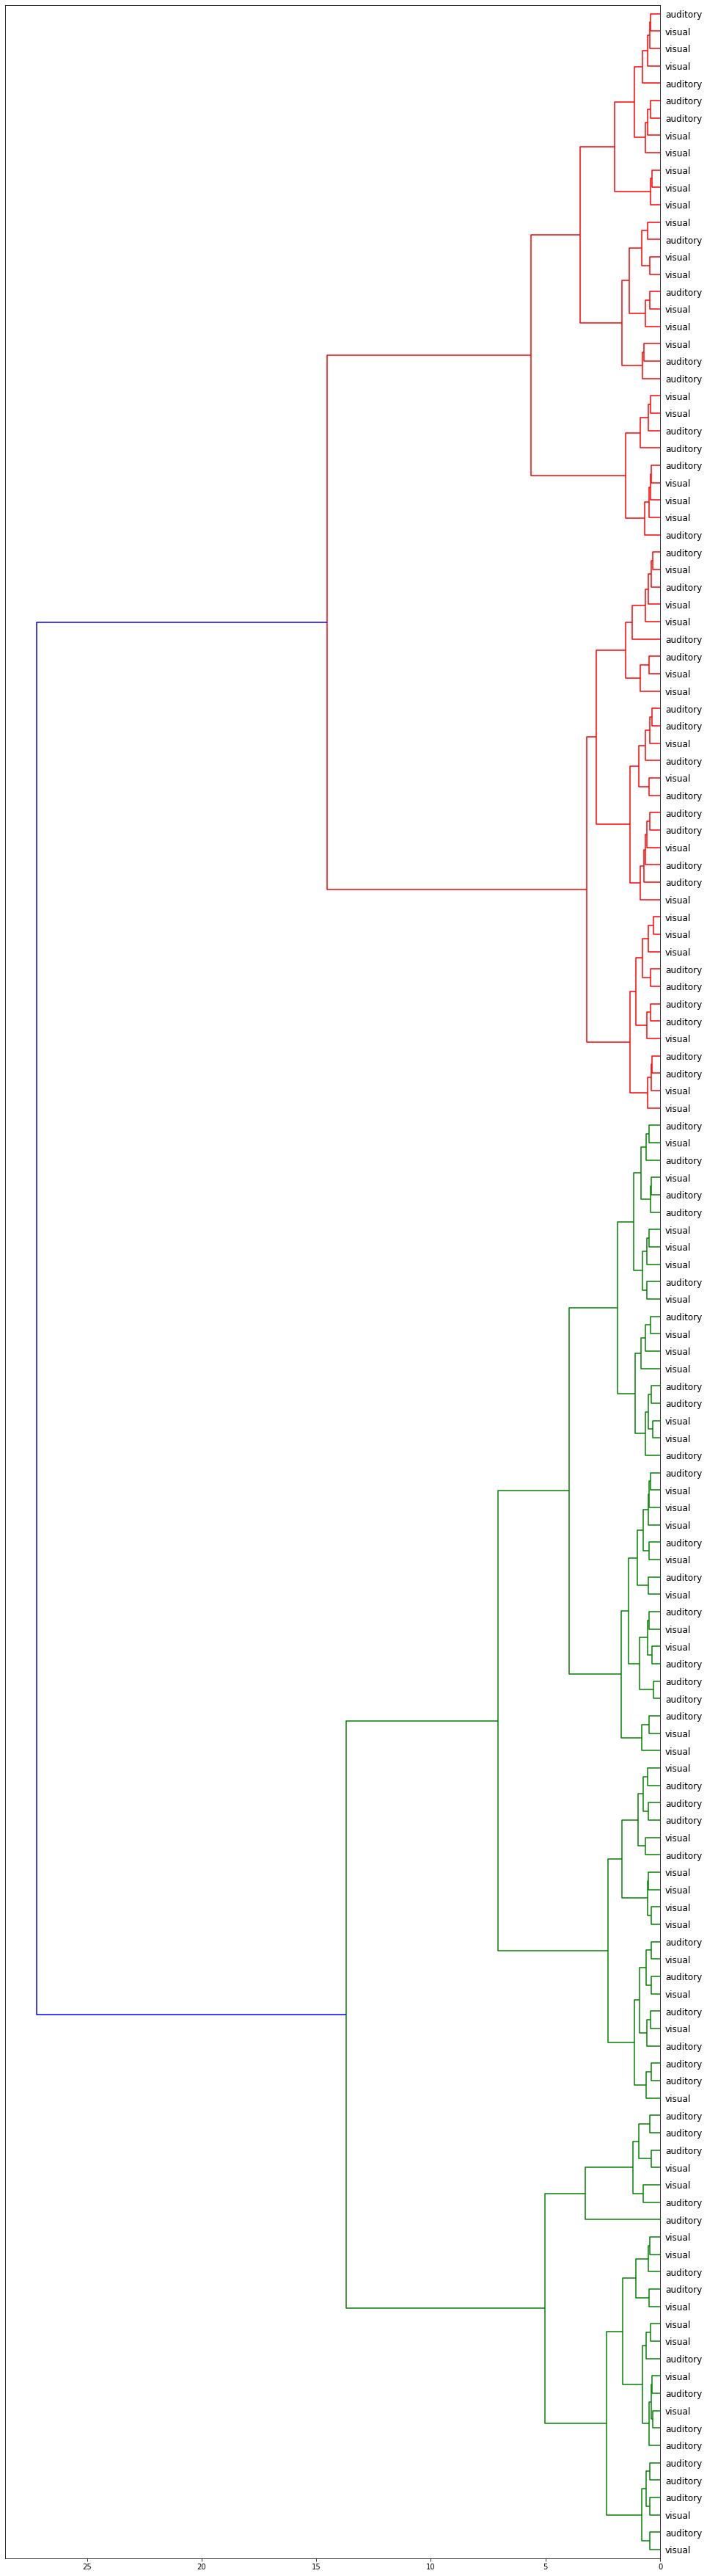

In [118]:
plot_hierarchy(ks_corr)

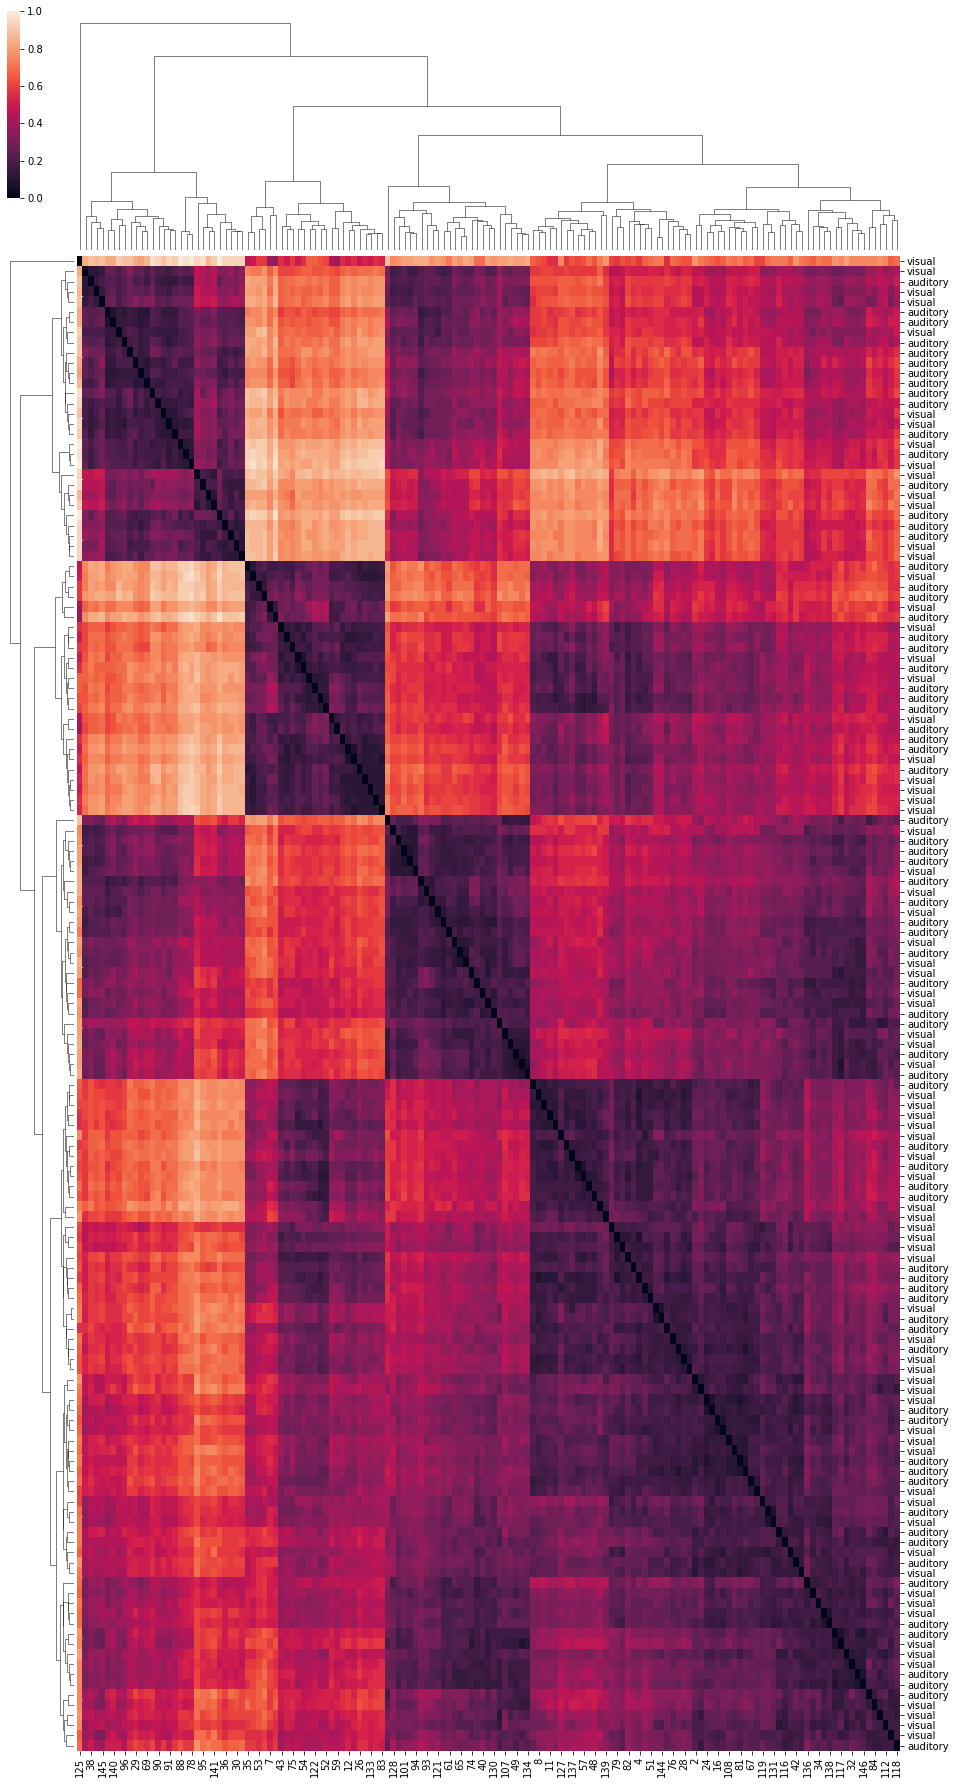

In [119]:
g = sns.clustermap(ks_corr, 
                   figsize=(16, 32),
                   yticklabels=[timestamps['stimulus_type'][i] for i in dg['leaves']])

In [320]:
##########################
# PCA on scaled power data
##########################
# 3D PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(power_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

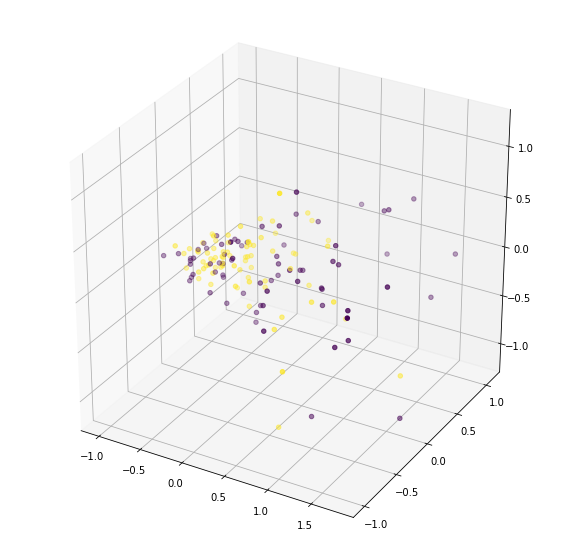

In [324]:
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
%matplotlib inline
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
ax.scatter(principalDf['principal component 1'], 
           principalDf['principal component 2'], 
           principalDf['principal component 3'], 
           c=y.reshape(147))
# plt.plot(principalDf)
plt.show()

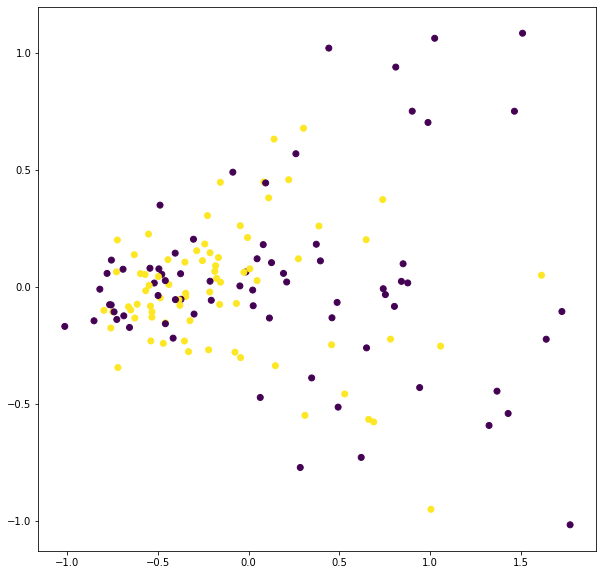

In [311]:
# 2D PCA
%matplotlib inline
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(power_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
fig = plt.figure(figsize = (10, 10))
#ax = plt.axes(projection='3d')
plt.scatter(principalDf['principal component 1'], 
           principalDf['principal component 2'], 
           c=y.reshape(147))
# plt.plot(principalDf)
plt.show()

In [125]:
##########################
# deep temporal clustering
##########################
# https://arxiv.org/pdf/1802.01059.pdf
# add code size then do feature extraction on code?
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.layers import UpSampling1D, Reshape

encoder = Sequential()
# (batch, 100, 36) -> (batch, 50, 72)
encoder.add(Conv1D(filters=72, kernel_size=3, activation='relu', padding='same', input_shape=(n_length, n_features)))
encoder.add(MaxPool1D(pool_size=2))
# (batch, 50, 72) -> (batch, 25, 144)
encoder.add(Conv1D(filters=144, kernel_size=3, activation='relu', padding='same'))
encoder.add(MaxPool1D(pool_size=2))
# (batch, 25, 144) -> (batch, 5, 288)
encoder.add(Conv1D(filters=288, kernel_size=3, activation='relu', padding='same'))

decoder = Sequential()
decoder.add(Conv1D(filters=288, kernel_size=3, activation='relu', padding='same'))
decoder.add(UpSampling1D(size=2))
decoder.add(Conv1D(filters=144, kernel_size=3, activation='relu', padding='same'))
decoder.add(UpSampling1D(size=2))
decoder.add(Conv1D(filters=36, kernel_size=3, activation='sigmoid', padding='same'))
#decoder.add(Reshape([n_length, n_features]))

autoencoder = Sequential([encoder, decoder])

encoder.summary()
decoder.summary()
autoencoder.summary()
#autoencoder.compile(loss='mse', optimizer=SGD(learning_rate=1.5), metrics=['accuracy'])
autoencoder.compile(loss='mse', optimizer=RMSprop(), metrics=['accuracy'])

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 100, 72)           7848      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 50, 72)            0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 50, 144)           31248     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 25, 144)           0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 25, 288)           124704    
Total params: 163,800
Trainable params: 163,800
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_39"
_________________________________________________________________
Layer (type)            

In [127]:
train_X,valid_X,train_ground,valid_ground = train_test_split(X,
                                                             X, 
                                                             test_size=split, 
                                                             random_state=seed)

#autoencoder.fit(train_X, train_ground, epochs=n_epochs, validation_data=(valid_X, valid_ground))
autoencoder_train = autoencoder.fit(train_X, train_ground, 
                                    #batch_size=batch_size,
                                    epochs=100,
                                    verbose=1,
                                    validation_data=(valid_X, valid_ground),
                                    callbacks=[early_stop])

Train on 117 samples, validate on 30 samples
Epoch 1/100
117/117 [==============================] - 2s 18ms/sample - loss: 0.4385 - accuracy: 0.0031 - val_loss: 0.3192 - val_accuracy: 0.0110
Epoch 2/100
117/117 [==============================] - 0s 2ms/sample - loss: 0.3395 - accuracy: 0.0098 - val_loss: 0.3191 - val_accuracy: 0.0120
Epoch 3/100
117/117 [==============================] - 0s 2ms/sample - loss: 0.3393 - accuracy: 0.0108 - val_loss: 0.3190 - val_accuracy: 0.0113
Epoch 4/100
117/117 [==============================] - 0s 2ms/sample - loss: 0.3392 - accuracy: 0.0107 - val_loss: 0.3189 - val_accuracy: 0.0110
Epoch 5/100
117/117 [==============================] - 0s 2ms/sample - loss: 0.3392 - accuracy: 0.0250 - val_loss: 0.3190 - val_accuracy: 0.0990
Epoch 6/100
117/117 [==============================] - 0s 2ms/sample - loss: 0.3392 - accuracy: 0.0999 - val_loss: 0.3432 - val_accuracy: 0.1037


In [140]:
######################
# X freq
######################
freq_upper_limit = 40 # truncate freq to 40Hz
X_freq = np.ndarray((X.shape[0], X.shape[2], freq_upper_limit))
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        freqs, psd = signal.welch(X[i,:,j], sf, nperseg=win)
        psd = psd[:freq_upper_limit]
        X_freq[i][j] = psd

X_freq.shape

(147, 36, 40)

In [141]:
X_freq = np.swapaxes(X_freq, 1, 2)
X_freq.shape

(147, 40, 36)

In [144]:
######################
# deep freq clustering
######################
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.layers import UpSampling1D, Conv2DTranspose, Reshape

encoder = Sequential()
# (batch, 40, 36) -> (batch, 20, 72)
encoder.add(Conv1D(filters=72, kernel_size=3, activation='relu', padding='same', input_shape=(freq_upper_limit, n_features)))
encoder.add(MaxPool1D(pool_size=2))
# (batch, 20, 72) -> (batch, 10, 144)
encoder.add(Conv1D(filters=144, kernel_size=3, activation='relu', padding='same'))
encoder.add(MaxPool1D(pool_size=2))
# (batch, 10, 144) -> (batch, 5, 288)
encoder.add(Conv1D(filters=288, kernel_size=3, activation='relu', padding='same'))

decoder = Sequential()
decoder.add(Conv1D(filters=288, kernel_size=3, activation='relu', padding='same'))
decoder.add(UpSampling1D(size=2))
decoder.add(Conv1D(filters=144, kernel_size=3, activation='relu', padding='same'))
decoder.add(UpSampling1D(size=2))
decoder.add(Conv1D(filters=36, kernel_size=3, activation='sigmoid', padding='same'))
#decoder.add(Reshape([n_length, n_features]))

autoencoder = Sequential([encoder, decoder])

encoder.summary()
decoder.summary()
#autoencoder.summary()
autoencoder.compile(loss='mse', optimizer=SGD(learning_rate=1.5), metrics=['accuracy'])
#autoencoder.compile(loss='mse', optimizer=RMSprop(), metrics=['accuracy'])

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 40, 72)            7848      
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 20, 72)            0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 20, 144)           31248     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 10, 144)           0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 10, 288)           124704    
Total params: 163,800
Trainable params: 163,800
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_45"
_________________________________________________________________
Layer (type)            

In [145]:
train_X,valid_X,train_ground,valid_ground = train_test_split(X_freq,
                                                             X_freq, 
                                                             test_size=split, 
                                                             random_state=seed)

#autoencoder.fit(train_X, train_ground, epochs=n_epochs, validation_data=(valid_X, valid_ground))
autoencoder_train = autoencoder.fit(train_X, train_ground, 
                                    #batch_size=batch_size,
                                    epochs=100,
                                    verbose=1,
                                    validation_data=(valid_X, valid_ground),
                                    callbacks=[early_stop])

Train on 117 samples, validate on 30 samples
Epoch 1/100
117/117 [==============================] - 1s 6ms/sample - loss: 0.2402 - accuracy: 0.0389 - val_loss: 0.2256 - val_accuracy: 0.0283
Epoch 2/100
117/117 [==============================] - 0s 1ms/sample - loss: 0.2144 - accuracy: 0.0419 - val_loss: 0.1850 - val_accuracy: 0.0300
Epoch 3/100
117/117 [==============================] - 0s 880us/sample - loss: 0.1510 - accuracy: 0.0440 - val_loss: 0.0546 - val_accuracy: 0.0308
Epoch 4/100
117/117 [==============================] - 0s 1ms/sample - loss: 0.0259 - accuracy: 0.0457 - val_loss: 0.0057 - val_accuracy: 0.0458
Epoch 5/100
117/117 [==============================] - 0s 948us/sample - loss: 0.0045 - accuracy: 0.0675 - val_loss: 0.0031 - val_accuracy: 0.0683
Epoch 6/100
117/117 [==============================] - 0s 930us/sample - loss: 0.0028 - accuracy: 0.0865 - val_loss: 0.0023 - val_accuracy: 0.1100
Epoch 7/100
117/117 [==============================] - 0s 903us/sample - loss: 

Epoch 54/100
117/117 [==============================] - 0s 908us/sample - loss: 4.6377e-04 - accuracy: 0.0752 - val_loss: 4.0276e-04 - val_accuracy: 0.0842
Epoch 55/100
117/117 [==============================] - 0s 840us/sample - loss: 4.6209e-04 - accuracy: 0.0752 - val_loss: 4.0110e-04 - val_accuracy: 0.0842
Epoch 56/100
117/117 [==============================] - 0s 984us/sample - loss: 4.6049e-04 - accuracy: 0.0752 - val_loss: 3.9952e-04 - val_accuracy: 0.0842
Epoch 57/100
117/117 [==============================] - 0s 999us/sample - loss: 4.5896e-04 - accuracy: 0.0752 - val_loss: 3.9801e-04 - val_accuracy: 0.0842
Epoch 58/100
117/117 [==============================] - 0s 893us/sample - loss: 4.5751e-04 - accuracy: 0.0752 - val_loss: 3.9658e-04 - val_accuracy: 0.0842
Epoch 59/100
117/117 [==============================] - 0s 941us/sample - loss: 4.5612e-04 - accuracy: 0.0752 - val_loss: 3.9521e-04 - val_accuracy: 0.0842
Epoch 60/100
117/117 [==============================] - 0s 906us

[BernoulliRBM] Iteration 1, pseudo-likelihood = -85.83, time = 0.00s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -74.35, time = 0.00s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -64.85, time = 0.00s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -56.68, time = 0.00s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -49.59, time = 0.00s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -43.81, time = 0.00s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -39.01, time = 0.00s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -34.91, time = 0.00s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -31.25, time = 0.00s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -28.52, time = 0.00s


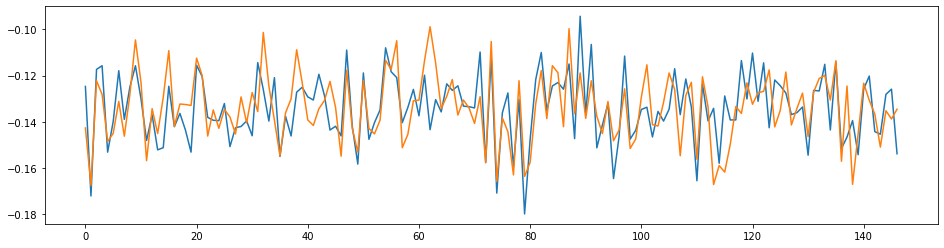

In [299]:
from sklearn.neural_network import BernoulliRBM
rbm = BernoulliRBM(n_components = 2, 
                   n_iter = 10, 
                   #learning_rate = 0.06, 
                   random_state=seed, verbose=True)
# rbm.fit(x_reshaped.T[:100])
rbm.fit(X_freq[:, :, 9].T)
# rbm.fit(corr)

plt.figure(figsize=(16, 4))
plt.plot(rbm.components_.T)
plt.show()

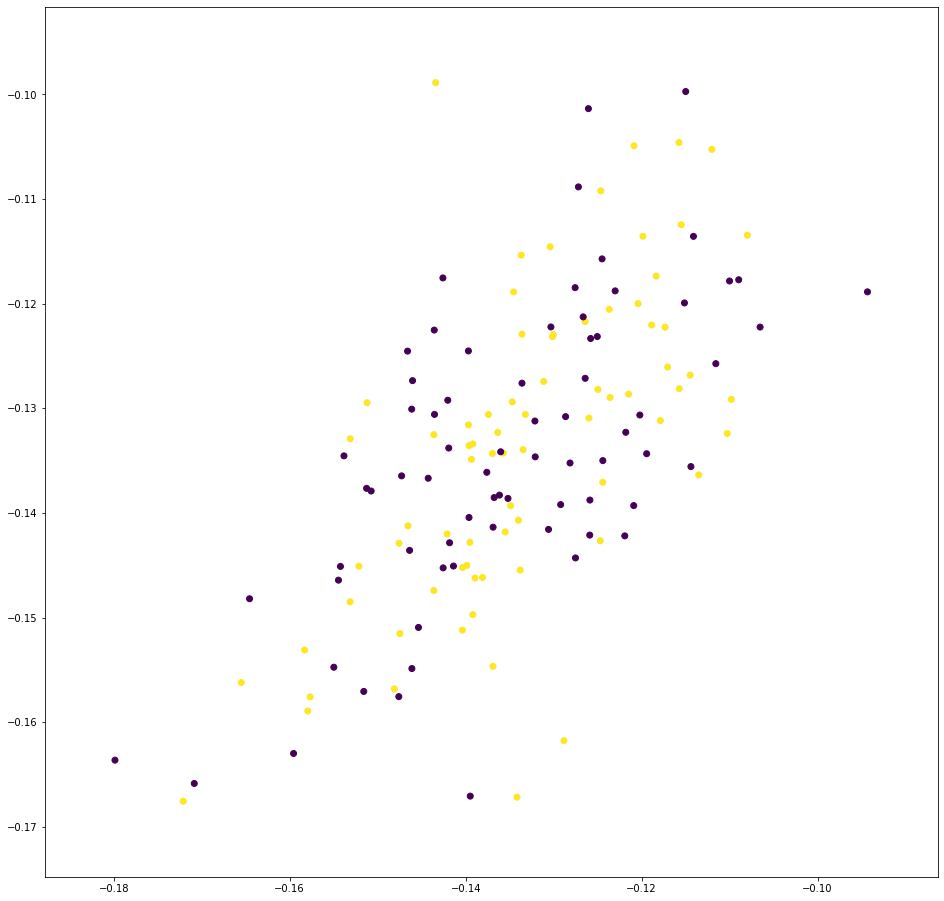

In [300]:
#%matplotlib notebook
# %matplotlib inline
plt.figure(figsize=(16, 16))
plt.scatter(rbm.components_[0], rbm.components_[1], c=y.reshape(147))
# plt.scatter(rbm.components_[0], rbm.components_[1], rbm.components_[2], c=y.reshape(147))
plt.show()

In [220]:
x_reshaped.T[:100].shape

(100, 147)

In [272]:
rbm.components_.shape

(1, 147)

In [273]:
# https://arxiv.org/pdf/1809.04356.pdf
# pd.DataFrame(rbm.components_).to_csv(os.path.join(DATA_PATH, 'components_rbm'), index = False)

In [330]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(rbm.components_.T)

In [331]:
kmeans.labels_

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1], dtype=int32)

In [372]:
kmeans.cluster_centers_

array([[-0.12342793, -0.12394119],
       [-0.14509683, -0.14436452]])

In [375]:
X.shape

(147, 100, 36)

In [481]:
#wavelet plot
def wavelet_plot(data):   
    cwtmatr = signal.cwt(data, signal.ricker, np.arange(1,31))
    plt.figure(figsize = (12, 3))
    plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    plt.show()

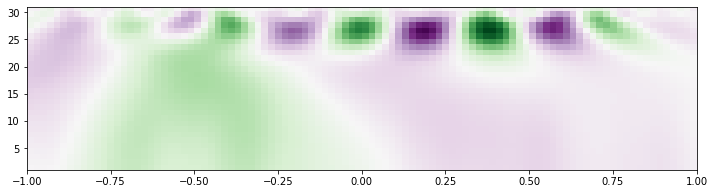

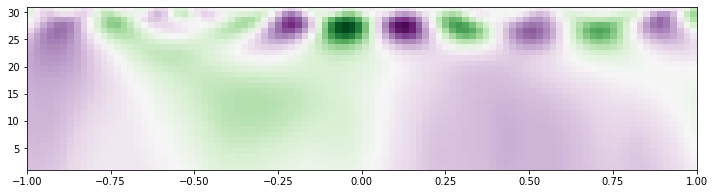

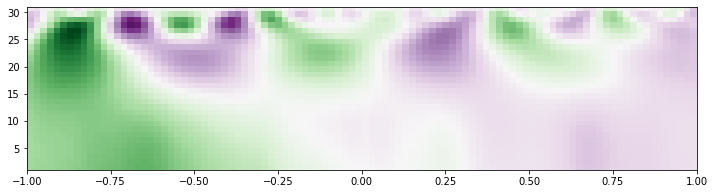

				new stimulus start



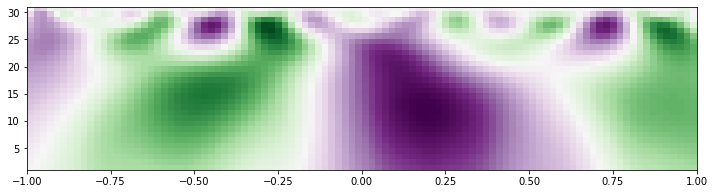

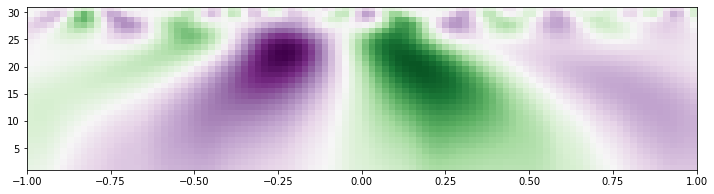

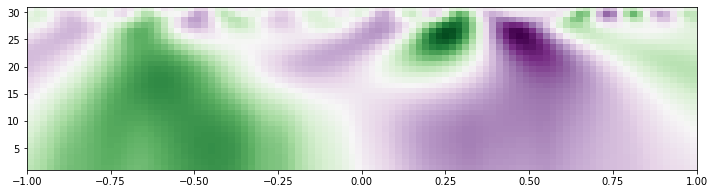

In [482]:
channel_num = 12
# new_stimulus: 25, 49, 74, 98, 123
new_stimulus = 25
wavelet_plot(X[new_stimulus - 3,:,channel_num])
wavelet_plot(X[new_stimulus - 2,:,channel_num])
wavelet_plot(X[new_stimulus - 1,:,channel_num])
print('\t\t\t\tnew stimulus start\n')
wavelet_plot(X[new_stimulus,:,channel_num])
wavelet_plot(X[new_stimulus + 1,:,channel_num])
wavelet_plot(X[new_stimulus + 2,:,channel_num])

#need to be pretrained even "unsupervised" for current test?
#better have location information